# Key Project Strategy Simulator - Bulge Events

The essential procedure for this simulation follows that outlined in kp_simulator.ipynb, but adapted for events detected in the Galactic Bulge by OGLE and MOA.

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate, optimize
import h5py
from os import path

## Bulge Event Sky Locations

OGLE and MOA have observed an extensive region in the Galactic Bulge for about 25yrs from single-site telescopes in Chile and New Zealand respectively.  More recently, KMTNet has begun to observe a slightly smaller and overlapping region from its three sites in Chile, Australia and South Africa at high (~15min) cadence.  This means that events in this region essentially do not need follow-up within this central high cadence zone, but selected events in the surrounding annulus still do.  

The notebook bulge_extended_survey_region identifies those regions where follow-up is still of value, and outputs a map of the expected rate of events within this region, which we read in here. 

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [3]:
map_file_path = 'bulge_extended_zone_map.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
49146,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
49147,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a distribution function for events in RA, Dec.  However, unlike for Gaia and ZTF, we also want to keep the exclusion zone in the centre of the Bulge, so no smoothing is done here. 

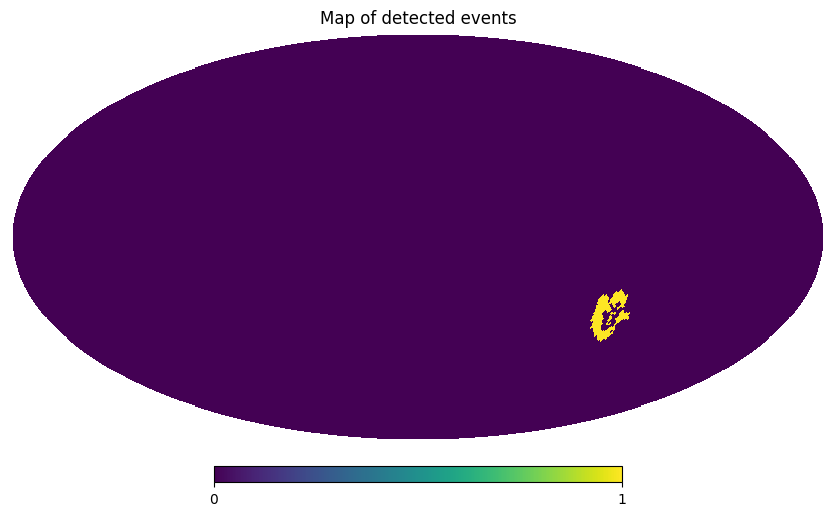

In [4]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0
hp.mollview(true_event_map, title='Map of detected events')

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [5]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

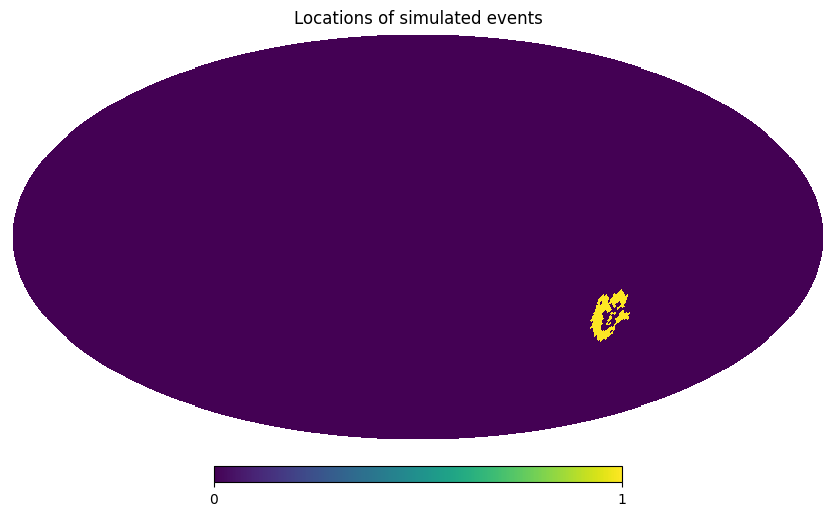

In [6]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0
hp.mollview(sim_event_map, title='Locations of simulated events')

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -29.31319722)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (263.671875, -30.)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (272.109375, -23.31795556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (272.8125, -30.69158611)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -22.02431111)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, -22.66960833)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -35.68533333)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -26.61009722)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -20.74237778)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (267.1875, -22.66960833)>"


## Bulge Event Baseline Magnitudes

Next we need to simulate the lightcurve data that OGLE or MOA would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  We derive this by examining the information from the OGLE Early Warning System (http://ogle.astrouw.edu.pl/ogle4/ews/) since this is the easist catalog to machine parse and is the largest and most self-consistent.  The MOA events are drawn from the same overall region, so this should be representative for both surveys.  

The code harvest_ogle_events.py was used to download the full dataset on OGLE alerted events, including data on the baseline magnitude and blend flux.  

In [8]:
def read_ogle_catalog(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            s = SkyCoord(row[1], row[2], frame='icrs', unit=(u.hourangle, u.deg))
            mag = float(row[3])
            f_bl = float(row[4])
            data.append([row[0], row[1], row[2], mag, f_bl, s])
    data = np.array(data)

    event_table = Table(
                        [Column(data=data[:,0], name='Event'),
                        Column(data=data[:,1], name='RA'),
                        Column(data=data[:,2], name='Dec'),
                        Column(data=data[:,3], name='Mag'),
                        Column(data=data[:,4], name='Blending'),
                        Column(data=data[:,5], name='Coordinate')]
                        )

    return event_table

In [9]:
catalog_file = './ogle/ogle_event_data.csv'
ogle_catalog = read_ogle_catalog(catalog_file)
ogle_catalog

Event,RA,Dec,Mag,Blending,Coordinate
object,object,object,object,object,object
OGLE-2002-BLG-001,17:51:16.16,-30:12:31.4,16.638,0.422,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.81733333, -30.20872222)>"
OGLE-2002-BLG-002,17:50:45.43,-30:04:13.9,17.692,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.68929167, -30.07052778)>"
OGLE-2002-BLG-003,17:54:25.85,-29:54:27.5,18.812,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.60770833, -29.90763889)>"
OGLE-2002-BLG-004,17:53:55.77,-29:53:32.0,17.424,0.267,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.482375, -29.89222222)>"
OGLE-2002-BLG-005,17:57:10.20,-29:43:41.8,18.576,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.2925, -29.72827778)>"
OGLE-2002-BLG-006,17:56:29.86,-29:26:27.5,18.542,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.12441667, -29.44097222)>"
...,...,...,...,...,...
OGLE-2018-BLG-1797,18:07:42.29,-26:39:42.6,15.694,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.92620833, -26.66183333)>"
OGLE-2018-BLG-1798,18:11:17.15,-25:16:52.1,17.425,1.0,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.82145833, -25.28113889)>"


Text(0.5, 1.0, 'Distribution of baseline magnitudes of OGLE events')

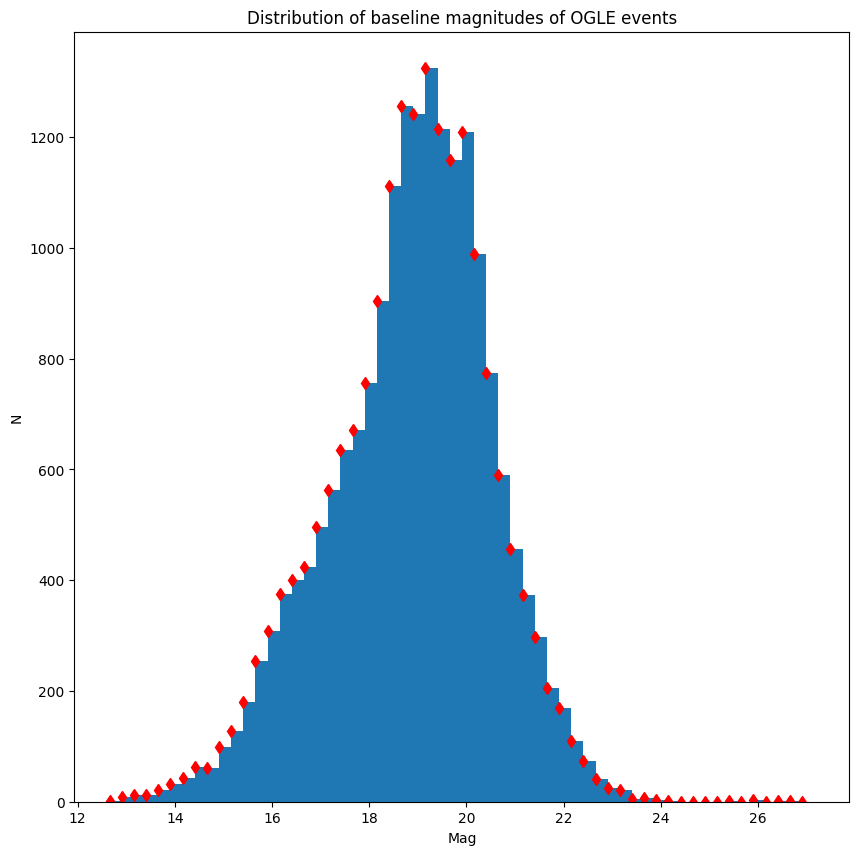

In [10]:
mag_min = ogle_catalog['Mag'].min()
mag_max = ogle_catalog['Mag'].max()
(mag_dist, mag_bins) = np.histogram(ogle_catalog['Mag'], bins=np.arange(mag_min, mag_max, 0.25))


fig = plt.figure(1,(10,10))
plt.hist(ogle_catalog['Mag'], bins=mag_bins)
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of baseline magnitudes of OGLE events')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for OGLE detections

Text(0.5, 1.0, 'Distribution of simulated OGLE detections')

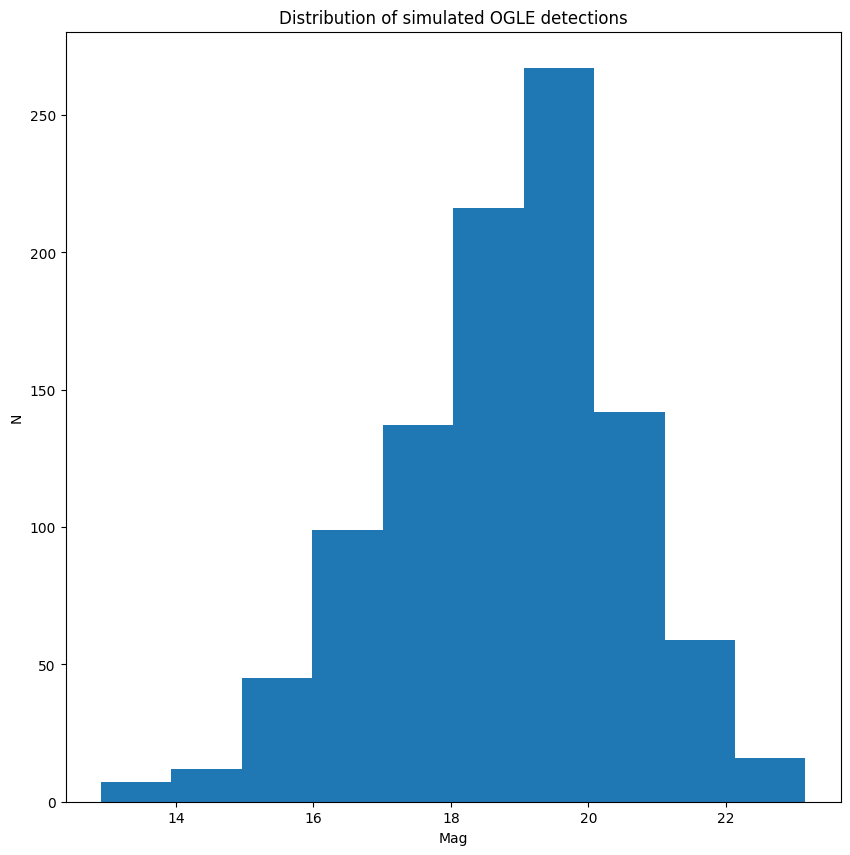

In [11]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated OGLE detections')

Blending
The density of stars in the Galactic Bulge is sufficiently high that we cannot assume that photometry for an event will not also include flux from neighboring stars within the PSF of both survey and follow-up telescopes. The OGLE catalog provides a sample of events where the blend ratio parameter f_bl = f_source / f_blend, and so equals 1.0 in cases with no blending.

Text(0.5, 1.0, 'Distribution of blend ratios=f_s/f_b of OGLE events')

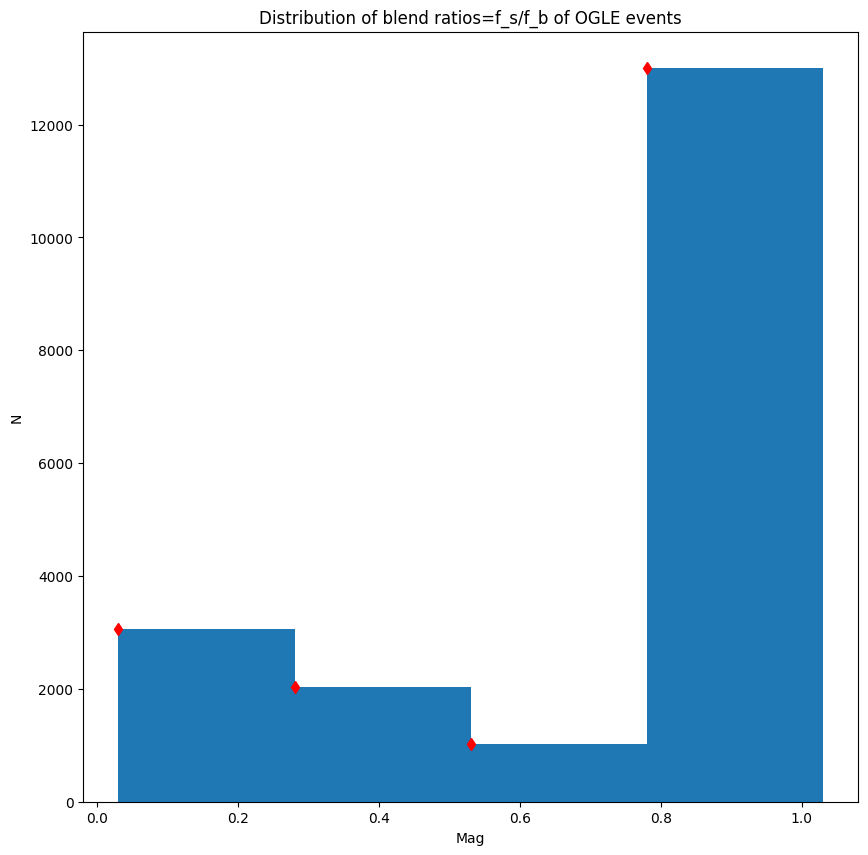

In [12]:
fbl_min = ogle_catalog['Blending'].min()
fbl_max = ogle_catalog['Blending'].max() + 0.25
(fbl_dist, fbl_bins) = np.histogram(ogle_catalog['Blending'], bins=np.arange(fbl_min, fbl_max, 0.25))

fig = plt.figure(1,(10,10))
plt.hist(ogle_catalog['Blending'], bins=fbl_bins)
plt.plot(fbl_bins[0:-1], fbl_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of blend ratios=f_s/f_b of OGLE events')

Similarly, we use this to assign realistic blend ratios for the simulated events

Text(0.5, 1.0, 'Distribution of simulated OGLE blend radios')

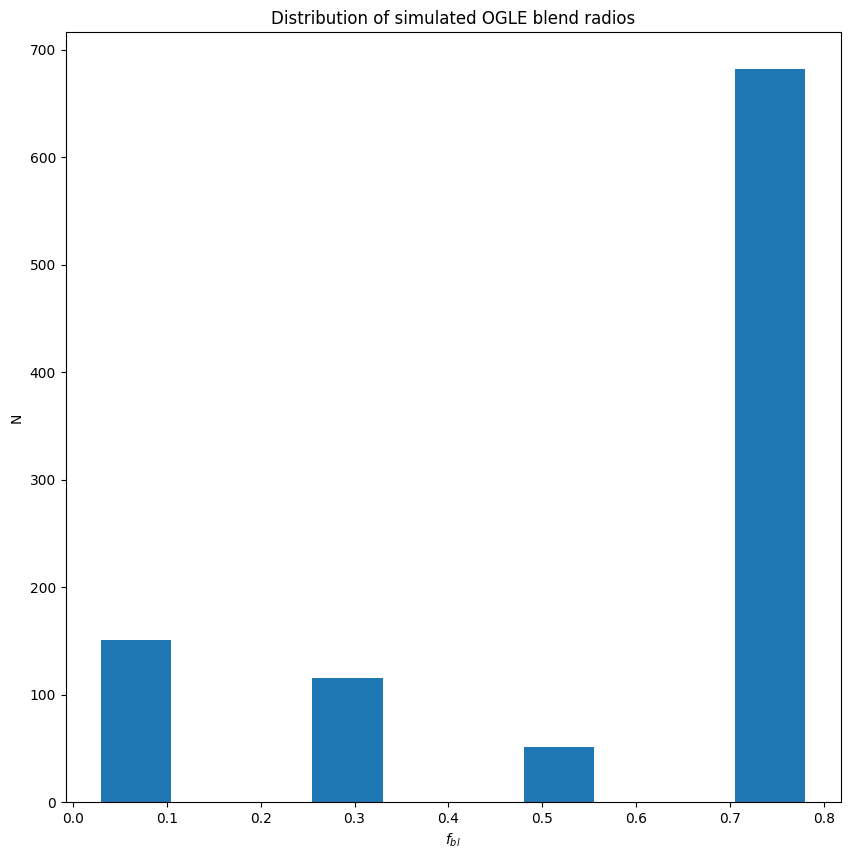

In [13]:
sim_event_fbl = random.choices(fbl_bins[0:-1], weights=fbl_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_fbl)
plt.xlabel('$f_{bl}$')
plt.ylabel('N')
plt.title('Distribution of simulated OGLE blend radios')

## Bulge Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the Key Project:

In [14]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2461252.50000

In [15]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [16]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

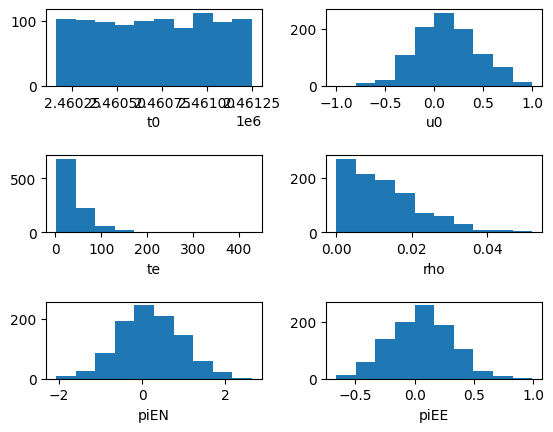

In [17]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

For ease of handling, let's combine these data into a single events table

In [18]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('BulgeSim'+roundID(x))

In [19]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="blend_ratio", data=sim_event_fbl, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        ])
events_table

EventID,HP,location,baseline_mag,blend_ratio,t0,u0,te,rho,piEN,piEE,nvisits
str13,int64,object,str32,str32,float64,float64,float64,float64,float64,float64,float64
BulgeSim00001,36673,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -29.31319722)>",20.158,0.78,2460978.6227221857,0.10720051562726751,13.644123306985902,0.012997654827090031,0.5356476155715353,-0.025764260710137217,0.0
BulgeSim00002,36923,"<SkyCoord (ICRS): (ra, dec) in deg\n (263.671875, -30.)>",17.908,0.03,2460436.597731858,0.19489641206229594,33.43321420786672,0.04175824060859723,0.2984384645866673,-0.25628374212372146,0.0
BulgeSim00003,34369,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.109375, -23.31795556)>",20.658,0.78,2460590.8711274015,0.06730925290087482,114.68384671573214,0.010125936745778745,1.3958886185673607,-0.4223491925263896,0.0
BulgeSim00004,37186,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.8125, -30.69158611)>",20.658,0.78,2461060.2792787515,0.09929258088932644,10.50914005902569,0.004442057599805017,0.17876496088593374,-0.07197390793454933,0.0
BulgeSim00005,33855,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -22.02431111)>",19.658,0.78,2460340.7808642546,0.31422148926727,17.29572679150827,0.006500096229397576,0.38338033016250195,-0.2623020073190785,0.0
BulgeSim00006,34111,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, -22.66960833)>",20.158,0.03,2460784.2660978283,0.24370145241338645,25.180907443324745,0.0047048245565066765,0.38112990091993965,0.12052639445342508,0.0
...,...,...,...,...,...,...,...,...,...,...,...
BulgeSim00994,33854,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -22.02431111)>",20.408,0.03,2460328.1844821987,0.36761306250291403,58.03292444678419,0.017881477963050812,0.008924279491830972,0.279396952552857,0.0
BulgeSim00995,39227,"<SkyCoord (ICRS): (ra, dec) in deg\n (262.96875, -36.42357222)>",16.408,0.03,2460939.2707949514,0.7264953359989266,12.344003782509754,0.006777542894926833,-1.0112468610052636,0.2538318968344011,0.0


## OGLE Event Lightcurve sampling

The OGLE survey team have indicated that they expect to adjust their survey strategy from 2023 onwards to survey the extended Bulge region with a cadence of 1-2 visits per field per night.  

OGLE Bulge survey operations typically run between Feb 1 to Oct 1 each year, following the Bulge annual visibility from their site in Chile.  MOA operate on a similar timescale from their site in New Zealand, and we assume a similar cadence from them for all events.  The expected survey cadence per event is therefore 2-4 visits per night, though in reality the number of visits per field is likely to drop towards the extreme ends of the season.  Our strategy would select only targets which are relatively poorly sampled by the surveys, so we assume 1-2 datapoints per survey per night. 

This is likely to produce a fairly consistent number of datapoints for all events.  

In [20]:
# Number of days in each month, and the expected number of visits per day for each month
seasons = {}

# 2023 - Key Project starts in 8/1/2023, so can observe only Aug, Sept
seasons[2023] = {'months': np.array([8, 9]),
                 'n_days_season': np.array([30, 30]), 
                 'nvisits_per_field': np.array([3, 2])}

# 2024 - will observe Feb - Sept inclusive
seasons[2024] = {'months': np.array([2, 3, 4, 5, 6, 7, 8, 9]),
                 'n_days_season': np.array([28, 31, 30, 31, 30, 31, 31, 30]), 
                 'nvisits_per_field': np.array([2, 2, 3, 3, 3, 3, 2, 2])}

# 2025 - will observe Feb - Sept inclusive
seasons[2025] = {'months': np.array([2, 3, 4, 5, 6, 7, 8, 9]),
                 'n_days_season': np.array([28, 31, 30, 31, 30, 31, 31, 30]), 
                 'nvisits_per_field': np.array([2, 2, 3, 3, 3, 3, 2, 2])}

# 2026 - will observe to end of Key Project period 7/31/2026
seasons[2026] = {'months': np.array([2, 3, 4, 5, 6, 7]),
                 'n_days_season': np.array([28, 31, 30, 31, 30, 31]), 
                 'nvisits_per_field': np.array([2, 2, 3, 3, 3, 3])}

nvisits = 0
for year in range(2023,2027,1):
    nv = (seasons[year]['n_days_season'] * seasons[year]['nvisits_per_field']).sum()
    nvisits += nv
print('Maximum number of survey visits = '+str(nvisits))

Maximum number of survey visits = 1846


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [21]:
events_table['nvisits'] = [nvisits]*len(events_table)  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,blend_ratio,t0,u0,te,rho,piEN,piEE,nvisits
str13,int64,object,str32,str32,float64,float64,float64,float64,float64,float64,int64
BulgeSim00001,36673,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -29.31319722)>",20.158,0.78,2460978.6227221857,0.10720051562726751,13.644123306985902,0.012997654827090031,0.5356476155715353,-0.025764260710137217,1846
BulgeSim00002,36923,"<SkyCoord (ICRS): (ra, dec) in deg\n (263.671875, -30.)>",17.908,0.03,2460436.597731858,0.19489641206229594,33.43321420786672,0.04175824060859723,0.2984384645866673,-0.25628374212372146,1846
BulgeSim00003,34369,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.109375, -23.31795556)>",20.658,0.78,2460590.8711274015,0.06730925290087482,114.68384671573214,0.010125936745778745,1.3958886185673607,-0.4223491925263896,1846
BulgeSim00004,37186,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.8125, -30.69158611)>",20.658,0.78,2461060.2792787515,0.09929258088932644,10.50914005902569,0.004442057599805017,0.17876496088593374,-0.07197390793454933,1846
BulgeSim00005,33855,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -22.02431111)>",19.658,0.78,2460340.7808642546,0.31422148926727,17.29572679150827,0.006500096229397576,0.38338033016250195,-0.2623020073190785,1846
BulgeSim00006,34111,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, -22.66960833)>",20.158,0.03,2460784.2660978283,0.24370145241338645,25.180907443324745,0.0047048245565066765,0.38112990091993965,0.12052639445342508,1846
...,...,...,...,...,...,...,...,...,...,...,...
BulgeSim00994,33854,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -22.02431111)>",20.408,0.03,2460328.1844821987,0.36761306250291403,58.03292444678419,0.017881477963050812,0.008924279491830972,0.279396952552857,1846
BulgeSim00995,39227,"<SkyCoord (ICRS): (ra, dec) in deg\n (262.96875, -36.42357222)>",16.408,0.03,2460939.2707949514,0.7264953359989266,12.344003782509754,0.006777542894926833,-1.0112468610052636,0.2538318968344011,1846


Store the table of simulated event parameters

In [22]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='blend_ratio', array=events_table['blend_ratio'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits', array=events_table['nvisits'], format='I5'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_bulge_events_table.fits', overwrite=True)


## Bulge Event Lightcurves

Now we can simulate the lightcurves that OGLE+MOA would produce for these simulated events, assuming the strategy described above for single-filter lightcurves (combined into the same survey lightcurve array, for convenience), since the majority of the constraint on the lightcurve parameters comes from data taken in I band.  

Firstly though, we need to establish a photometric noise function for the magnitude uncertainties in the lightcurve. We do this using data for an example event OGLE-2019-BLG-0461, downloaded from the OGLE EWS system, and fit a simple function to represent the photometric noise model.

In [23]:
def straight_line(x, a, b):
    return a + b*x

Text(0.5, 1.0, 'Photometry for example Bulge event OGLE-2019-BLG-0461')

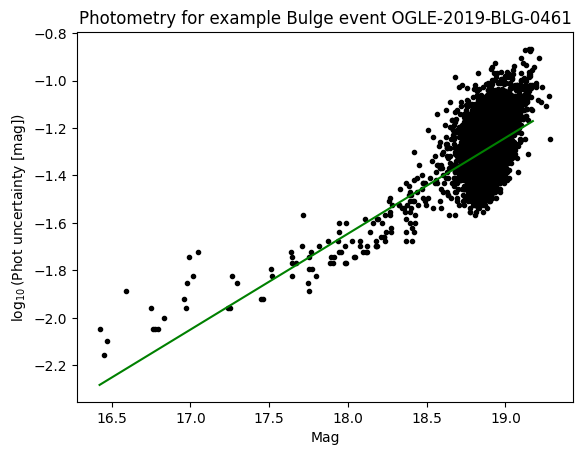

In [24]:
file_path = './ogle/blg-0461/phot.dat'
data = np.loadtxt(file_path)
mag = data[:,1]
mag_err = data[:,2]
log_mag_err = np.log10(mag_err)

(noise_model, fcov) = optimize.curve_fit(straight_line, mag, log_mag_err)
xdata = np.arange(mag.min(), mag.max(), 0.25)
ydata = straight_line(xdata, noise_model[0], noise_model[1])

plt.plot(mag, log_mag_err, 'k.')
plt.plot(xdata, ydata, 'g-')
plt.xlabel('Mag')
plt.ylabel('$\log_{10}$(Phot uncertainty [mag])')
plt.title('Photometry for example Bulge event OGLE-2019-BLG-0461')

In [25]:
def convert_flux_to_mag(flux, flux_err):
    """Function to convert the flux of a star from its fitted PSF model
    and its uncertainty onto the magnitude scale.

    :param float flux: Total star flux
    :param float flux_err: Uncertainty in star flux
run
    Returns:

    :param float mag: Measured star magnitude
    :param float flux_mag: Uncertainty in measured magnitude
    """

    def flux2mag(ZP, flux):
        return ZP - 2.5 * np.log10(flux)

    # Weed out any negative fluxes
    idx = np.where(flux < 0.0)
    flux[idx] = 0.0
    flux_err[idx] = 0.0
    
    ZP = 27.4 # As used by PyLIMA

    mag = flux2mag(ZP, flux)
    mag_err = (2.5 / np.log(10.0)) * flux_err / flux

    return mag, mag_err

def convert_mag_to_flux(mag, mag_err):
    """Function to convert the flux of a star from its fitted PSF model
    and its uncertainty onto the magnitude scale.

    :param float flux: Total star flux
    :param float flux_err: Uncertainty in star flux

    Returns:

    :param float mag: Measured star magnitude
    :param float flux_mag: Uncertainty in measured magnitude
    :param float flux: Total flux, scaled by the exposure time if given
    :param float flux_err: Uncertainty on total flux, scaled by the exposure
                            time, if given
    """

    ZP = 27.4 # As used by PyLIMA

    flux = 10**( (mag - ZP) / -2.5 )

    ferr = mag_err/(2.5*np.log10(np.e)) * flux

    return flux, ferr


In [26]:
def simulate_event_bulge(event_params, noise_model, start_date, end_date, 
                         seasons, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Simulate timestamps of observations
    timestamps = np.array([])
    for year, config in seasons.items():
        for imonth,month in enumerate(config['months']):
            t1 = Time(str(year)+'-0'+str(month)+'-01 00:00:00', format='iso', scale='utc')
            t2 = Time(str(year)+'-0'+str(month)+'-'+str(config['n_days_season'][imonth])+' 00:00:00', format='iso', scale='utc')
            start = t1.jd
            end = t2.jd
            cadence = 1.0/config['nvisits_per_field'][imonth]
            ts = np.arange(start, end, cadence)
            #print(str(year)+'-'+str(month)+' '+str(start)+' to '+str(end)+': '+str(ts.min())+' to '+str(ts.max()))
            timestamps = np.concatenate((timestamps, ts))
    
   
    # Create a PyLIMA event object
    sim_event = event.Event()
    sim_event.name = event_params['EventID']
    sim_event.ra = float(event_params['location'].ra.deg)
    sim_event.dec = float(event_params['location'].dec.deg)

    # Generate a constant lightcurve at the event's baseline magnitude (neglecting differences due to color), 
    # with fixed photometric uncertainties, since these will be replaced later
    lc = np.zeros((len(timestamps),3))
    lc[:,0] = timestamps
    lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
    lc[:,2] = [0.01] * len(timestamps)
    print(float(event_params['baseline_mag']), np.median(lc[:,1]))

    # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
    tel = telescopes.Telescope(name='OGLEMOA', camera_filter='I',
                                    light_curve_magnitude=lc,
                                    location='Earth',
                                    light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                    clean_the_lightcurve=False)

    sim_event.telescopes.append(tel)
    sim_event.find_survey('OGLEMOA')

    # Add a PyLIMA model to the event, using the simulated parameters
    if parallax:
        sim_model = microlmodels.create_model('FSPL', sim_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]

    else:
        sim_model = microlmodels.create_model('FSPL', sim_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho'])]

    sim_model.define_model_parameters()

    if parallax:
        sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)

    tel = sim_model.event.telescopes[0]

    pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
    
    # Add simulated blending to the parameter set, bearing in mind that OGLE's definition is the inverse of PyLIMA's
    pylima_parameters.g_OGLEMOA = float(event_params['blend_ratio']) 
    
    # Use the blend ratio to create both source and blend unlensed lightcurves
    # f(t) = A(t)*f_s(t) + f_b 
    lightcurve = sim_event.telescopes[0].lightcurve_magnitude
    (unlensed_lc, flux_err) = convert_mag_to_flux(lightcurve[:,1], lightcurve[:,2]) # Unlensed source lightcurve
    source_flux = unlensed_lc * float(event_params['blend_ratio'])
    blend_flux = unlensed_lc * (1.0 -float(event_params['blend_ratio']))      # Blend lightcurve (inc sim noise)
    
    # Use the PyLIMA model to add a lensing event into the source lightcurve
    magnification = sim_model.model_magnification(tel, pylima_parameters)
    A = sim_model.model_magnification(tel,pylima_parameters)
    source_flux *= A
    
    # Observed lightcurve is the combination of both lensed source and blend
    flux = source_flux + blend_flux
    
    # Convert back to magnitudes and use the noise model to calculate the photometric uncertainties
    (lightcurve[:,1], mag_err) = convert_flux_to_mag(flux, flux_err)
    log_errors = straight_line(lightcurve[:,1], noise_model[0], noise_model[1])
    lightcurve[:,2] = 10**(log_errors)
    
    sim_event.telescopes[0].lightcurve_magnitude = lightcurve
    print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))

    return sim_event, sim_model, lensing_parameters

Parallax for Bulge events is predominately the annual parallax signature caused by the motion of the Earth during an event, which PyLIMA can calculate internally.  

In [27]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

(sim_event, sim_model, lensing_parameters) = simulate_event_bulge(events_table[event_number], noise_model, start_date, end_date, seasons, parallax=True)



Picked bright event:  1  baseline_mag= 17.908 mag
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.90799182135322


   EventID      HP                            location                          baseline_mag blend_ratio         t0                 u0                 te                rho                piEN                piEE         nvisits
------------- ----- ----------------------------------------------------------- ------------ ----------- ----------------- ------------------- ----------------- ------------------- ------------------ -------------------- -------
BulgeSim00002 36923 <SkyCoord (ICRS): (ra, dec) in deg\n    (263.671875, -30.)>       17.908        0.03 2460436.597731858 0.19489641206229594 33.43321420786672 0.04175824060859723 0.2984384645866673 -0.25628374212372146    1846
[[2.46015750e+06 1.79079778e+01 2.07585874e-02]
 [2.46015783e+06 1.79079777e+01 2.07585851e-02]
 [2.46015817e+06 1.79079776e+01 2.07585827e-02]
 ...
 [2.46125150e+06 1.79079997e+01 2.07590115e-02]
 [2.46125183e+06 1.79079997e+01 2.07590115e-02]
 [2.46125217e+06 1.79079997e+01 2.07590116e-02]]


Text(0.5, 1.0, 'Simulated event BulgeSim00002')

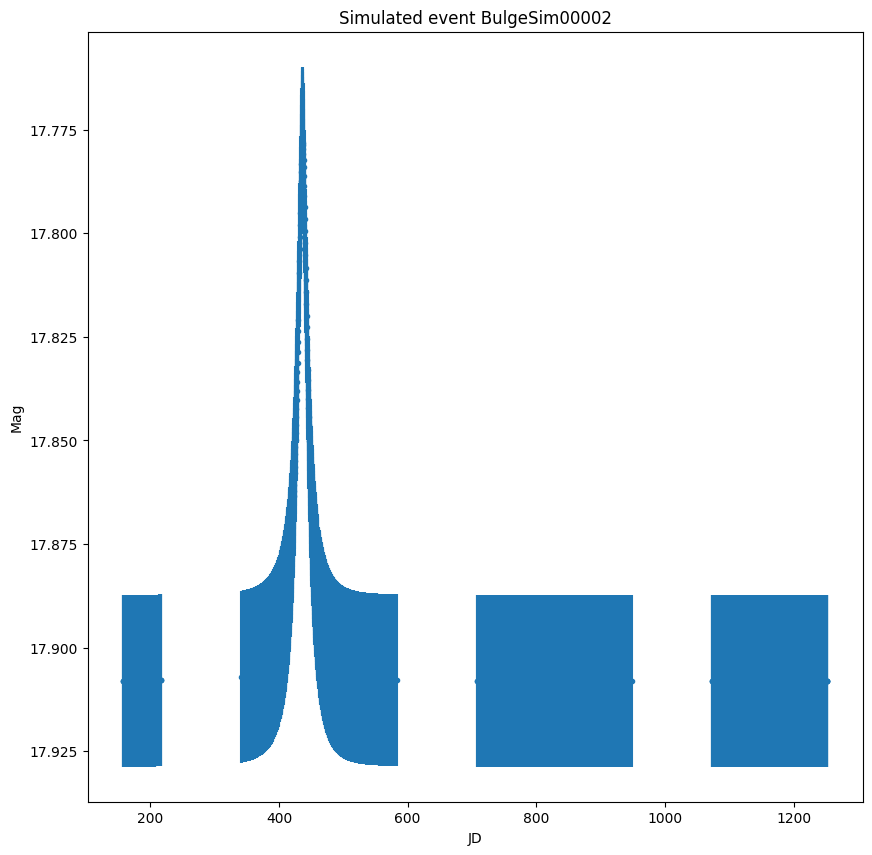

In [28]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = sim_event.telescopes[0].lightcurve_magnitude
print(lc)
plt.errorbar(lc[:,0]-2460000.0, lc[:,1], yerr=lc[:,2], fmt='.')
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

Simulate all events

In [29]:
sim_bulge_lenses = []
sim_bulge_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (bulge_lens, bulge_lens_model, lens_model_pars) = simulate_event_bulge(events_table[ievent], noise_model, start_date, end_date, seasons, parallax=True)
    sim_bulge_lenses.append(bulge_lens)
    sim_bulge_lens_models.append(bulge_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

20.158 20.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.157982016568777
0 [2460978.6227221857, 0.10720051562726751, 13.644123306985902, 0.012997654827090031, 0.5356476155715353, -0.025764260710137217]
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.90799182135322
1 [2460436.597731858, 0.19489641206229594, 33.43321420786672, 0.04175824060859723, 0.2984384645866673, -0.25628374212372146]
20.658 20.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.658 20.652096135753048
2 [2460590.8711274015, 0.06730925290087482, 114.68384671573214, 0.010125936745778745, 1.3958886185673607, -0.4223491925263896]
20.658 20.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.658 20.657996777843884
3 [2461060.2792787515, 0.09929258088932644, 10.50914005902569, 0.004442057599805017, 0.17876496088593374, -0.07197390793454933]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.65799684

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15751545304317
37 [2461154.496350564, 0.1470204068030179, 53.591732971942584, 0.011855222962269098, 0.28618014047609175, 0.15409011161319833]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907370347493273
38 [2461000.074770712, 0.07757914512872376, 29.02358118785496, 0.004513294361561516, -0.3428320777153076, 0.3447155444867841]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.90797897890912
39 [2461075.456334849, -0.08712688695534329, 51.38514234031853, 0.00214131639313725, 1.0690245827652387, -0.09212664092121656]
16.408 16.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.408 16.40799996158412
40 [2460443.62901582, 0.9345617501478325, 5.3351511006405, 0.0061351024144020005, 0.8201005250018036, -0.10919161675666947]
14.158 14.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
14.158 14.157994900192936
41 [2460526.7

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.40411966202576
75 [2460789.6326121152, -0.15878490871136228, 69.79067227672698, 0.0033998710514256385, 0.04033296265209073, -0.04167942885024153]
16.658 16.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.658 16.657999984123776
76 [2460438.637651875, 0.242150932204784, 4.370680364251951, 0.005708521369855297, 0.6901761339032326, 0.015341586942937253]
22.408 22.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
22.408 22.40799975116914
77 [2460173.5018317797, -0.031177123549992414, 11.673050097602816, 0.018592017982677865, -0.3250898036544557, -0.16194075783135325]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.40789877166818
78 [2460313.208396372, 0.027297852561777566, 72.90962640475148, 0.006203076324432836, 1.1304580619215703, -0.11721558322463721]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907703377637926
7

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407940109979897
111 [2461202.356665471, 0.23726611325152433, 58.465663721999064, 0.003165449192109554, 1.0751135135285275, 0.6086758279081383]
20.408 20.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.40713350010629
112 [2461070.3185695363, -0.1132940343725605, 67.1599503920575, 0.02029737660075858, 0.9674232152277535, -0.183339484620457]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157984078249402
113 [2460270.107990172, 0.02583776889001868, 28.043640051756782, 0.0022777783193370493, 0.049261881273822, 0.03548178412687566]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.657374021082685
114 [2460918.222876631, 0.42786193361973446, 39.674874585098785, 0.02402930183102485, -0.055522359125353526, 0.0012883347346062599]
21.158 21.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.158 21.157607398396422
115

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.65777608948317
147 [2460345.173338176, 0.08896025838036531, 109.17527215976394, 0.005121935214978288, 1.7895589672716579, 0.2342550083875653]
20.408 20.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.407999974864424
148 [2460332.9794052215, 0.5671338242559829, 5.103603146703451, 0.0043388965475789545, 0.03803009871675084, -0.39852772491304816]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.6577623848939
149 [2460838.3526831493, 0.33373963515123684, 67.0051736239486, 0.0019691714447476454, 0.1932828830436628, 0.7212699904146602]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.37177204425408
150 [2460563.3971417993, 0.7728236144586426, 178.3102052592527, 0.011379395868771774, 0.717105665081478, 0.2776020017538926]
22.408 22.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
22.408 22.407996762738094
151 [2460

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.15789775145766
183 [2460270.181336692, -0.0668195210382356, 47.58486437922773, 0.010042296199989184, -0.8771152942478273, 0.3578502071295822]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157989327975436
184 [2460180.3425588654, 0.2964189350169125, 41.79475255155969, 0.007338879091780713, 1.8498204133684994, 0.11240539973632904]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157987785345206
185 [2461008.715277963, 0.8646647190567757, 31.85850304317192, 0.01480964956430313, 0.39986329857317526, -0.16396940419558612]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.657864829869254
186 [2460240.06581575, 0.29595445133100967, 45.25738144127866, 0.0012219523294037153, 1.1655012675063412, 0.23351008115803584]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15342491954032
187 [246

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.158 21.157991926694187
219 [2460264.0878664185, -0.05249852762635579, 27.770378815970293, 0.037846825338334285, 1.182128168425773, -0.1525348931587765]
21.408 21.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.408 21.407881766693254
220 [2460812.025695957, 0.342592711035388, 43.253291203793786, 0.0076817759557232124, 1.101462093800597, 0.4305200119251965]
20.408 20.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.40577624249281
221 [2461039.1445075995, 0.09554040484929319, 67.17048669414962, 0.0013002819028542067, -0.44423380872437096, 0.12444825110019445]
21.158 21.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.158 21.15455793637636
222 [2460453.477586372, 0.33157872662989396, 193.52630401090647, 0.016657484291618507, 0.5108992024116159, 0.2696658255524336]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.657933951552693
223 

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.158 21.157954658969654
255 [2461158.9807670913, -0.01134544039668317, 30.053607506472858, 0.008548122580804266, -0.707283134830955, 0.19640237682748185]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.65798241357298
256 [2461188.1748083998, -0.3186706152257184, 25.310008342495728, 0.0031855384926861366, -0.8114171940714294, 0.12188082067701173]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.370532746593582
257 [2460592.182391096, 0.020244019877266553, 162.5127305541139, 0.016450596890666074, 0.4874665496169034, -0.016793279034999754]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.902250215633572
258 [2460768.810605617, 0.10107731125316824, 94.35911538555064, 0.0041608484237661576, -0.6286208885075806, 0.3364739260817794]
20.408 20.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.407160785807

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.408 15.367035647722659
291 [2461006.9032841977, -0.07468038964025026, 125.40975358335399, 0.0018031903505093018, 0.4244051234143065, 0.3564790710205678]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.655023649484953
292 [2460303.9969845787, 0.06828406989050491, 63.732865713421, 0.01809964787062688, -0.06813253570596206, 0.37473944856910735]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907998141123286
293 [2460413.873635678, 0.34654615844004144, 16.224839678719675, 0.02053083187438942, 0.5513066740158826, 0.13576236466537053]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.657991410217434
294 [2460552.005425056, -0.15100548975645947, 18.537370793698678, 0.02512465450881904, -0.39661067824948243, 0.22667952554426904]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15798337974233
2

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.149075706432164
327 [2460972.3289726875, 0.5683020858207002, 62.990669825404524, 0.04159818667109, 0.5119798724195155, 0.3133242185576203]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157997273350173
328 [2460918.2506520995, 0.0553195653724356, 25.186858895168484, 0.014259628519079855, 1.95642312812907, 0.05523696032890642]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907942068972893
329 [2460381.993540416, 0.5697364347962299, 30.786455439476725, 0.00697652890839698, 0.387069535559157, 0.22976708884955824]
16.408 16.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.408 16.4073879375584
330 [2460714.311112283, -0.09937574966598442, 83.30584712972839, 0.010552584789358709, 0.3330729689900602, 0.26700130446694914]
17.408 17.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.408 17.407999695040886
331 [2460367.5

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.158 18.157986785081
363 [2460810.061850476, 0.12794600388623129, 22.631290365978053, 0.013080986722295932, 1.5399424769747596, 0.4492986665062669]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907996204661618
364 [2460172.3047973285, 0.16724638652777635, 24.707414327939116, 0.020376502657687708, 0.39866204354595614, 0.16166156343527263]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.65799935392873
365 [2460214.0315547423, 0.3875673565236528, 14.430192662282481, 0.00020756609171346772, 1.1201959907160588, 0.3486548324736968]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.402883486511804
366 [2461027.7202502526, 0.43293640154887014, 53.900281563570104, 0.0007192457157041837, -0.4273005009189705, 0.19880037936580855]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.65496865250655
36

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.40603313732567
399 [2460925.6078332495, 0.2635737359590213, 56.74846923758764, 0.028360143203234565, -0.9226311070807169, -0.04734178729392099]
16.908 16.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.907999828736912
400 [2460874.234547683, 0.08941111614021896, 5.651352658368186, 0.016207822460107685, 0.6335295661473305, 0.29585717861283045]
16.158 16.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.158 16.15797603632332
401 [2460424.0577097824, 0.07500430415132245, 55.72046072898736, 0.0023636113660785475, 0.1418914895862703, 0.15736267397044157]
17.158 17.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.158 17.157626581637203
402 [2460413.327814648, 0.5994164282251988, 48.484628990229965, 0.029057373817239024, 0.299120858698303, -0.32359145127600875]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.65799982345745
403 [

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.384057893214294
435 [2460734.757163811, 0.38180294420771554, 267.26166282623325, 0.0005571874114932308, 1.1595191148640742, 0.06046368978177176]
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.907999956389922
436 [2460315.074004611, 0.3268710953481043, 14.45295397907585, 0.010213508166130777, 1.7355306772681984, -0.05187371671679996]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157969856189887
437 [2460368.189806335, -0.4261087393779247, 30.997284375708077, 0.011202924376634154, 0.4755843992330285, -0.002098504453569003]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407999507706872
438 [2460425.239834953, 0.08952035188129666, 8.549220378516472, 0.004733539967894135, 0.3834064702965152, 0.2822662811059815]
22.408 22.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
22.408 22.407831523865184
43

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.907668818514196
471 [2460337.3530158494, 0.11165433231137833, 52.95349955424709, 0.03570855510184436, 0.616498887756624, 0.22068295044784655]
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.90799998362536
472 [2460904.7077549235, -0.27898640090908, 2.8862701509136914, 0.00228405172195025, -0.05259080705277966, -0.16954436953002705]
17.408 17.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.408 17.40772785493077
473 [2460774.2756081526, 0.4401637577745454, 33.33083900254016, 0.017560042865604253, -0.05262097731517512, -0.29789121846317257]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15792958418188
474 [2460567.3357195053, -0.1284739596435525, 20.65199077978996, 0.0021685681972804707, 0.749569608871522, -0.21713325642890094]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157999863616592
475

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.407169761951018
507 [2460386.53827547, 0.18285015284091272, 76.63975220483863, 0.00679464157634283, 0.9639967515085757, -0.30565229268617405]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.65176670722767
508 [2460616.596751428, 0.7673242042414165, 95.65471994754486, 0.0044004891185392934, 0.5055509914885072, -0.2198497078007738]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.646801057198644
509 [2460697.0111967153, 0.5387291848901896, 330.2060020345618, 0.025906763780734324, -0.3673372737766644, -0.23373620031320583]
20.408 20.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.407930577957913
510 [2460627.1001663697, -0.02231094307952028, 19.559931099535355, 0.01302853411135302, 1.1461195445935346, 0.18975368557791777]
15.908 15.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.908 15.907952449036316
511 

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157305117519154
543 [2460466.800396078, -0.38369034958984805, 62.134491842167925, 0.0032913516726511497, -0.20183549012455837, -0.017197621777762837]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.65042264268819
544 [2461078.019478322, -0.1060110177314188, 60.34538177765909, 0.005641668223451806, -0.01673699150418484, 0.31966010161025604]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907961398525853
545 [2460952.565350667, -0.08933120787278034, 18.26538582787626, 0.02773294241076652, -1.4572450081145072, -0.1845204545711307]
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.907934638773952
546 [2460497.2202411853, 0.06920211445343863, 58.75085478694744, 0.016657883630339446, 1.643250923578224, 0.5977739739111095]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.90797302152834

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407994873751374
579 [2461152.0238713366, -0.1970393662674462, 15.870185695122592, 0.00800172941774885, -1.1132703494014486, 0.2290226817328896]
21.908 21.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.908 21.907907591467485
580 [2460449.811793318, 0.07012389247332262, 31.427795244166703, 0.018147109830215363, 0.7689034375960724, 0.0263386905182553]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407964102349204
581 [2460586.7372069755, -0.048296697414103, 16.62687962031567, 0.018008890540813623, 0.8111855530982373, 0.17256936668118045]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.40749561903965
582 [2460733.197663157, -0.027235615993248558, 35.539797472524, 0.0196979728635807, 0.3480576693289363, 0.2486878347571009]
20.658 20.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.658 20.65798697869553
583 [24611

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.65799904217558
615 [2460484.8722157967, -0.03373257839956273, 19.71814034636339, 0.0035498092678377807, -0.1902953405035585, 0.035294303354068926]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.657991704911062
616 [2461059.949417192, 0.5471796667788262, 27.43323364406193, 0.027878107615154094, 0.6513995230384535, 0.3435578622425318]
17.408 17.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.408 17.40687733672152
617 [2460770.1043947474, 0.4819645224003126, 56.01572977156898, 0.0014882703916762625, 0.34710967712705326, 0.1757880704203614]
15.408 15.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.408 15.407997033336844
618 [2461060.799497089, -0.10259187297431946, 10.498569922697815, 0.0018587235543667813, -0.3597234654687897, 0.3441452355401907]
20.408 20.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.408 20.407984334724105
6

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.658 15.657747934169327
651 [2460708.5033380543, -0.06031711227422665, 139.92469265481088, 0.03055506379515742, 1.6905624226085096, 0.34510806468107347]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157975215425832
652 [2460198.612456164, 0.6260999275298409, 86.61840997744204, 0.01978301900097763, 0.7174025157885604, 0.2598612428178221]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.657950324184355
653 [2460807.2071958967, -0.2445188740379368, 30.19613816099903, 0.01593437137916557, 1.2792062254302226, 0.15022900257861066]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.896498533495308
654 [2460493.163859106, 0.15338367778132025, 143.13000353579477, 0.0036613796408328575, 0.21666104589725546, 0.053624442535040694]
20.158 20.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.156067978956976
655

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407957719175684
687 [2461034.5068078707, 0.22582047426244353, 42.8894758660322, 0.02522060425316225, 1.569327703181759, -0.10998465791694356]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407483800755706
688 [2461155.57946264, -0.010106620268506866, 50.636221543285956, 0.018246408560767147, 0.6409848321125007, -0.05167460032440121]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.6576789796624
689 [2460875.656701592, -0.04835197532905128, 46.62268509465825, 0.0019060165247156789, 1.0344133605378418, -0.04210527487752574]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.90767374213141
690 [2460339.3094845354, 0.25051534174857537, 66.42826418777638, 0.022868256075035225, 0.81053596622278, -0.045455464334408106]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907803091211274
691

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907993133549414
723 [2460817.089026228, 0.20014266959166316, 41.2002396153196, 0.011586790022590452, 1.3482547721393012, -0.1773113053821965]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.65771894782101
724 [2460891.1258612913, -0.08150615381809534, 33.83987446793977, 0.02374848722890016, 0.06818712220736553, -0.06803966622264396]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.657994465291782
725 [2460292.367050809, -0.19485534404130408, 21.517199121962353, 0.0009533751167399782, 0.46689131863860306, -0.07261843030488352]
21.408 21.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.408 21.407999946259018
726 [2460205.094773987, -0.24839067982750576, 9.948905872414121, 0.015186736688109185, 0.18876150097848599, 0.14831399031171674]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.65799763940317

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.40799747862455
759 [2460546.5670793247, -0.2126153431877075, 10.237282453123052, 0.016905686323242367, 1.3312980902638079, 0.4075044757502537]
16.908 16.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.90799982147366
760 [2460218.7766713877, -0.6171277053666583, 10.12829782018847, 0.002582318942412846, 0.1308543918146777, -0.03415558878386591]
20.158 20.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.15669425255537
761 [2460791.6135467137, -0.3381837074968935, 56.083982352222414, 0.024136814825661962, -0.5090521102095058, 0.06224260587328697]
16.908 16.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.90799882850265
762 [2460394.5362184155, -0.10086810365343299, 11.353165628703223, 0.016608436370399972, 0.31678097279189976, 0.3498885175699357]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.657986715003744
7

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.158 15.157977037847777
795 [2460229.554054432, -0.6172262705399622, 33.23633407195913, 0.01615377586545228, -0.01692150066604331, 0.2091757406179888]
21.158 21.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.158 21.157995239147255
796 [2461042.4175501266, 0.5329956398289729, 10.794414550575995, 0.004303391055739533, -0.390066546366099, -0.0514228876379751]
18.158 18.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.158 18.15789550954392
797 [2461142.561714612, 0.3439476212860233, 30.581446934117537, 0.006857618484274443, 0.8157748138012935, -0.21463328518153776]
17.658 17.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.658 17.657979056725363
798 [2461147.407183456, 0.12714799432010515, 22.94359412308085, 0.0007959983567019067, -0.02104286254196014, 0.27003205954539067]
20.158 20.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.158 20.157988534302454
79

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
21.408 21.407948201644896
831 [2461080.8145415382, 0.48253278386455745, 24.64004157704715, 0.004312347811406941, 0.9415419921285595, -0.26505492343135756]
18.408 18.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.40799998284143
832 [2460275.1852141856, 0.38703272594802957, 5.0424453496685455, 0.012256529782719336, -0.3981398742560463, 0.12852210907015507]
18.158 18.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.158 18.157999976667753
833 [2461072.4145100303, -0.0671431933843562, 7.061213528732894, 0.0024150995686191973, -0.19297023707326083, 0.026329809928503145]
18.158 18.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.158 18.157995808570025
834 [2460775.248670726, -0.044224408491320005, 32.45311283733106, 0.02693479269053354, 0.9290535416888268, 0.37040236400476134]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907665075174

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.408 18.407801206736856
867 [2461131.8928562286, 0.17139148230335138, 39.44938368977954, 0.0015731257112190245, 0.28028281011825124, 0.15098349045762555]
20.908 20.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.90796408629172
868 [2460728.195714575, 0.6706837963041221, 20.18168540523801, 0.015205788711878035, 1.6625053991327083, 0.44116406383244366]
19.658 19.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.658 19.657967837554818
869 [2460405.1640012087, 0.49760594460424046, 24.32408370038733, 0.005865219992332521, -0.044250485010277424, -0.2592249701175937]
17.158 17.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.158 17.15767208712235
870 [2460482.4351047757, 0.09883893890055204, 58.410919678303884, 0.005019711353451939, -0.6352489699064978, -0.061115106565541887]
16.908 16.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
16.908 16.9079676867452

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.15799423252859
903 [2460907.316381116, 0.08918347949005653, 13.193589961406621, 0.023356982329856175, -0.5368836095079959, 0.273396235425489]
19.408 19.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.408 19.407995233574557
904 [2460614.6623178665, 0.19766327050085966, 9.778279050284938, 0.0011708591740235835, -0.818058463819656, 0.17332391855864923]
17.908 17.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.908 17.90798266915752
905 [2460449.189233527, 0.29426105272695, 17.863156932222818, 0.022154134760012042, -0.10624042150084229, -0.2034740884052273]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.90793658251437
906 [2460808.322434431, -0.025564375523590616, 37.53509105354769, 0.015026551659432513, 1.1668930521306637, 0.5110995202563137]
19.158 19.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.158 19.157993218911173
907 [2

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
20.908 20.907999984915904
940 [2460545.227952306, -0.0871211223437478, 6.362729842889604, 0.0012768018826773437, -0.25445816068780686, 0.08554672490606718]
23.158 23.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
23.158 23.152361862114745
941 [2460564.0135653457, 0.27164234588713854, 65.69564149776113, 0.010268428453297923, 1.1528169592397859, 0.1760559627779498]
19.908 19.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
19.908 19.907453518436512
942 [2460959.4752541925, -0.5417375881730607, 82.45798829165457, 0.00952692894845747, -0.1712809973573211, 0.07418791310586977]
15.408 15.408
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
15.408 15.404131413120526
943 [2460630.0954529396, -0.13340552484730753, 51.701421343203386, 0.004796444927150419, 0.1310039253364589, 0.058465323272758885]
17.158 17.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
17.158 17.14996993734386

Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
14.658 14.655766373492416
976 [2460359.1330073215, -0.14339123794154093, 101.83269641068125, 0.015916702401142502, 0.7760790582030279, 0.03303829829801083]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907770961240224
977 [2460622.242420515, 0.20311899820336712, 25.253768581691972, 0.006801872040927892, -0.39810803198709616, 0.17068091038272476]
18.908 18.908
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.908 18.907941938746987
978 [2460350.459656271, 0.24319146433041533, 30.40606932044325, 0.0042044361142676775, 0.4117915053970136, 0.42316906965328166]
18.658 18.658
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.658 18.65799921390308
979 [2460777.2354932306, 0.03577168223656607, 10.765672558036012, 0.01992363859958611, 0.586082430724465, 0.3504464935890983]
18.158 18.158
Parallax(Full) estimated for the telescope OGLEMOA: SUCCESS
18.158 18.156753961148745
9

Store the simulated Bulge lightcurves

In [30]:
file_path = 'simulated_bulge_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_bulge_lenses),1):
        lc = sim_bulge_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [31]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

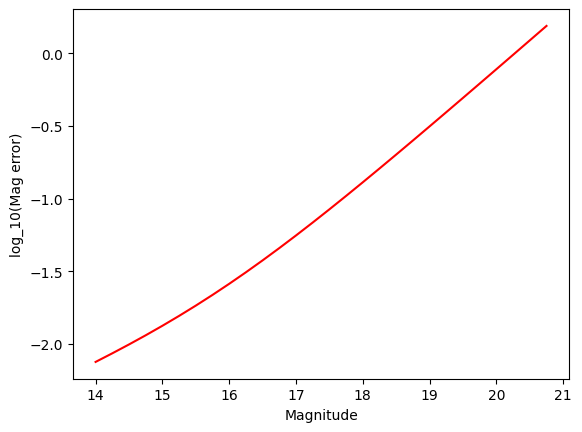

In [32]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [33]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [34]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [35]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated Bulge events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [36]:
def simulate_lco_observations(bulge_event, bulge_model, bulge_model_params, event_data, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    survey_lc = bulge_event.telescopes[0].lightcurve_magnitude
    if len(survey_lc) == 0:
        return bulge_event
    
    mag_threshold = 17.5
    bright_data = np.where(survey_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(survey_lc[:,1].min())+' no LCO observations')
        return bulge_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = bulge_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = bulge_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(bulge_event.ra, bulge_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = survey_lc[:,0].min()
    end_jd = survey_lc[:,0].max()
    
    # Long timescale events
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (survey_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = survey_lc[idx,0].min()
            pre_peak_end = survey_lc[idx,0].max()
            cadence = 1.0 # days
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = survey_lc[:,0].min()
            pre_peak_end = survey_lc[:,0].min()
            
        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = survey_lc[idx,0].min()
            post_peak_end = survey_lc[idx,0].max()
            cadence = 1.0 # days
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = survey_lc[:,0].max()
            post_peak_end = survey_lc[:,0].max()
            
        # Peak observations
        cadence = 1.0/24.0
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)
            
            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()
                
            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)
        
        ts = np.concatenate((ts1,ts2,ts3))
    
    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return bulge_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for the survey
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(survey_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    tel = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    if len(bulge_event.telescopes) == 2:
        bulge_event.telescopes[1] = tel
    elif len(bulge_event.telescopes) < 2:
        bulge_event.telescopes.append(tel)
    else:
        raise IOError('Too many lightcurves on this model')
    
    if parallax:
        bulge_model.event.compute_parallax_all_telescopes(bulge_model.parallax_model)
        
    tel = bulge_model.event.telescopes[-1]
    
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = bulge_model.compute_pyLIMA_parameters(bulge_model_params)
    print(event_data)
    pylima_parameters.g_OGLEMOA = float(event_data['blend_ratio'])
    
    # Add simulated blending to the parameter set, bearing in mind that OGLE's definition is the inverse of PyLIMA's
    #pylima_parameters.g_OGLEMOA = float(event_params['blend_ratio']) 
    
    # Use the blend ratio to create both source and blend unlensed lightcurves
    # f(t) = A(t)*f_s(t) + f_b 
    lightcurve = tel.lightcurve_magnitude
    (unlensed_lc, flux_err) = convert_mag_to_flux(lightcurve[:,1], lightcurve[:,2]) # Unlensed source lightcurve
    source_flux = unlensed_lc * pylima_parameters.g_OGLEMOA
    blend_flux = unlensed_lc * (1.0 - pylima_parameters.g_OGLEMOA)      # Blend lightcurve 
    
    # Use the PyLIMA model to add a lensing event into the source lightcurve
    magnification = bulge_model.model_magnification(tel, pylima_parameters)
    A = bulge_model.model_magnification(tel,pylima_parameters)
    source_flux *= A
    
    # Observed lightcurve is the combination of both lensed source and blend
    flux = source_flux + blend_flux
    
    # Convert back to magnitudes
    (lightcurve[:,1], mag_err) = convert_flux_to_mag(flux, flux_err)
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lightcurve[:,1])
    lightcurve[:,1] += phot_scatter * np.random.randn(len(lightcurve))
    
    # Calculate the photometric uncertainties
    lightcurve[:,2] = add_lco_noise(lightcurve[:,1])
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lightcurve[:,1] > mag_threshold)
    lightcurve = np.delete(lightcurve, idx, axis=0)
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lightcurve
    bulge_event.telescopes[1] = tel
    
    return bulge_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [37]:
event_number = 11
while (float(events_table[event_number]['baseline_mag']) > 17.0):
    event_number += 1
print('Picked new bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

bulge_lens = sim_bulge_lenses[event_number]
bulge_lens_model = sim_bulge_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

print(bulge_lens.telescopes)

updated_bulge_event = simulate_lco_observations(bulge_lens, bulge_lens_model, lens_model_pars, events_table[event_number], visibility_data)
print(bulge_lens.telescopes)



Picked new bright event:  11  baseline_mag= 14.908 mag
Event model parameters:  2460779.959203114 -0.32539129173991643 21.198598643147626 0.007320869877655246 0.43408995500219444 0.23514411767379054
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                  te                 rho                  piEN                piEE        nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ------------------ -------------------- ------------------- ------------------- -------
BulgeSim00012 33086 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.1875, -20.10550833)>       14.908        0.78 2460779.959203114 -0.32539129173991643 21.198598643147626 0.007320869877655246 0.43408995500219444 0.23514411767379054    1846
[<pyLIMA.telescopes.Telescope o

   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                  te                 rho                  piEN                piEE        nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ------------------ -------------------- ------------------- ------------------- -------
BulgeSim00012 33086 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.1875, -20.10550833)>       14.908        0.78 2460779.959203114 -0.32539129173991643 21.198598643147626 0.007320869877655246 0.43408995500219444 0.23514411767379054    1846
Got 2 lightcurves
[[2.46015750e+06 1.49079981e+01 1.27029744e-03]
 [2.46015783e+06 1.49079981e+01 1.27029744e-03]
 [2.46015817e+06 1.49079981e+01 1.27029743e-03]
 ...
 [2.46125150e+06 1.49079935e+01 1.27029198e-03]
 [2.46125183e+06 1.49079935e+01 1.27029200e-03]
 [2.46125217e+06 1.4907

Text(0.5, 1.0, 'Simulated event BulgeSim00012')

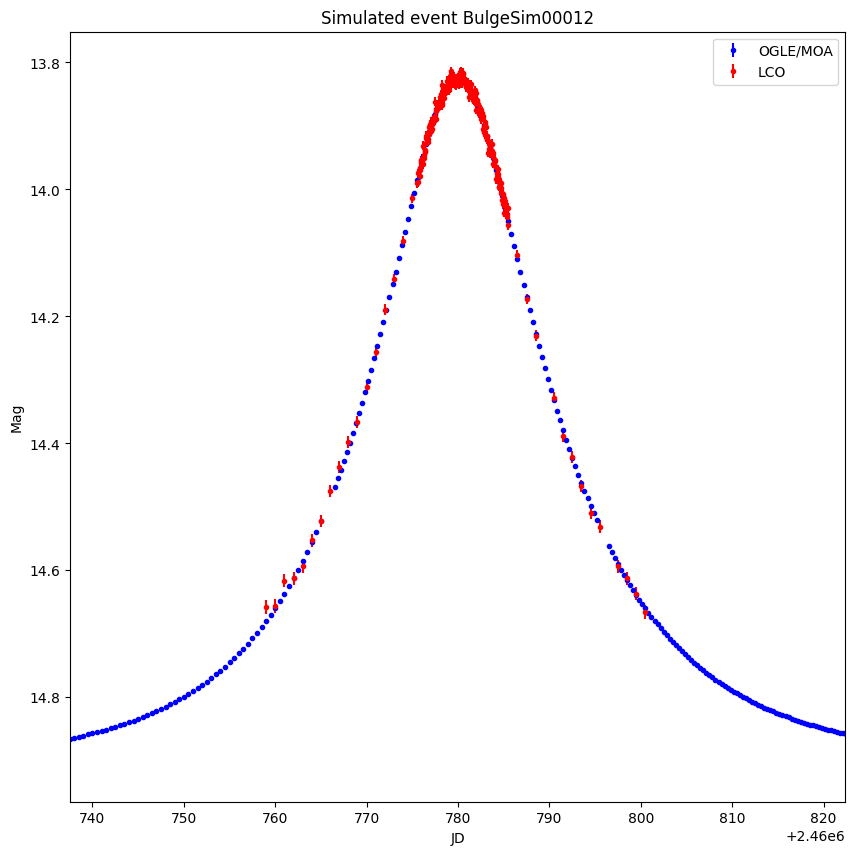

In [38]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
print('Got '+str(len(updated_bulge_event.telescopes))+' lightcurves')
lc1 = updated_bulge_event.telescopes[0].lightcurve_magnitude
print(lc1)
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='OGLE/MOA', fmt='b.')
lc2 = updated_bulge_event.telescopes[1].lightcurve_magnitude
print(lc2)
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])

We can now simulate LCO observations for the full set of simulated Bulge events

In [39]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_bulge_event = simulate_lco_observations(sim_bulge_lenses[ievent], 
                                                   sim_bulge_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   events_table[ievent],
                                                   visibility_data)
    simulated_events_list.append(updated_bulge_event)

Faint event, min 20.122772251695483 no LCO observations
Faint event, min 17.778171928447627 no LCO observations
Faint event, min 18.47149266426787 no LCO observations
Faint event, min 20.468860169477374 no LCO observations
Faint event, min 18.550653339479897 no LCO observations
Faint event, min 20.058662307904143 no LCO observations
Faint event, min 19.923355131226266 no LCO observations
Faint event, min 18.59604117039326 no LCO observations
Event model parameters:  2460287.740947076 0.5198853886949817 19.21999727977606 0.005749447277284693 1.1006514971715984 0.024547880694164838
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                u0                 te                rho                 piEN                piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- -------

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                rho                  piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ----------------- -------------------- ------------------- ------------------- -------
BulgeSim00035 34366 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.890625, -23.31795556)>       17.408        0.53 2460883.9099321063 0.04840223936622891 76.24419095419523 0.012503325776228287 0.15772955400458627 -0.3749399362284563    1846
Faint event, min 17.810113505785633 no LCO observations
Event model parameters:  2460766.1465738555 0.3746798757838039 81.1056132326982 0.005278579596216991 1.0838159606126982 -0.28284388119930337
Parallax(Full) estimated for t

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                             baseline_mag blend_ratio         t0                 u0                 te                 rho                  piEN               piEE        nvisits
------------- ----- ---------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ -------------------- ------------------- ------------------ -------
BulgeSim00069 35132 <SkyCoord (ICRS): (ra, dec) in deg\n    (264.375, -25.28260278)>       18.408        0.78 2460185.568192438 0.32638702404426834 11.475110170996683 0.013160826195431298 0.13404606398654464 0.5226727741989765    1846
Faint event, min 18.034702639625745 no LCO observations
Faint event, min 18.484247683777944 no LCO observations
Event model parameters:  2461002.0991338925 0.7682898385558964 58.36217346861859 0.007529140650052555 -0.8591341075293255 -0.20

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                te                rho                  piEN               piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ---------------- -------------------- ------------------- ------------------ -------
BulgeSim00094 34371 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.921875, -23.31795556)>       17.408        0.78 2460333.4234947083 0.39653530294962924 73.0969584731647 0.023499643641517264 -0.5156991326980558 0.1903377618196532    1846
Faint event, min 19.368957190913655 no LCO observations
Event model parameters:  2460602.5282976073 0.08721552861430956 28.325223895918796 0.006229842981945765 0.8628625875261267 -0.08992196145752326
Parallax(Full) estimated for the 

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ ------------------- ------------------- ------------------- -------
BulgeSim00108 35395 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.921875, -25.94447778)>       17.908        0.78 2460956.832204766 0.08961863051264218 17.332281335252947 0.00767898710690791 0.23099828051993535 0.20039197482179175    1846
Event model parameters:  2460841.2320377934 0.3745205732595416 15.169687316599619 0.0012535135739420921 0.8609219337270195 0.14517078871894468
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP             

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                 piEN                 piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ------------------ ------------------- -------------------- -------------------- -------
BulgeSim00134 36417 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.109375, -28.63098889)>       17.408        0.78 2461000.7836488634 0.12683644437852043 24.908349010176156 0.00793201443112656 -0.21123895112938978 -0.28067949270689607    1846
Faint event, min 17.58441078358731 no LCO observations
Event model parameters:  2460647.0111600086 0.6417198562369589 89.38080145926754 0.011271960813424822 -0.26154428616352526 -0.06477471465393028
Parallax(Full) estimat

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                 te                 rho                piEN                piEE         nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ ------------------- ------------------ -------------------- -------
BulgeSim00163 36162 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.8125, -27.95318611)>       16.908        0.78 2460654.460582393 -0.2979871494009174 11.495524694882013 0.01412394611038337 1.0431210274278524 0.007737197944107092    1846
Event model parameters:  2460946.3581482703 0.26845908005368824 25.077001103486637 0.003817142067966811 -0.0014979444175079737 0.5146009897322571
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio        t0                 u0                 te                 rho                 piEN                piEE        nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ---------------- ------------------- ----------------- --------------------- ------------------ ------------------- -------
BulgeSim00187 37182 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.1875, -30.69158611)>       17.658        0.78 2460240.06581575 0.29595445133100967 45.25738144127866 0.0012219523294037153 1.1655012675063412 0.23351008115803584    1846
Faint event, min 18.654165839083035 no LCO observations
Faint event, min 19.550295434868595 no LCO observations
Event model parameters:  2460512.53070798 -0.03992447309457545 19.774696828704908 0.02803778618628352 1.1724778783785141 -0.004

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                            baseline_mag blend_ratio         t0                u0                 te                 rho                piEN              piEE        nvisits
------------- ----- --------------------------------------------------------------- ------------ ----------- ----------------- ------------------ ------------------ ------------------- ----------------- ------------------ -------
BulgeSim00210 37691 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.96875, -32.08995)>       17.158        0.78 2460650.418266115 0.6527598774038127 21.614508077382872 0.01865234891047715 0.862640520032623 -0.636060706118328    1846
Faint event, min 18.10596695859472 no LCO observations
Faint event, min 18.38345399831915 no LCO observations
Faint event, min 18.47581205138649 no LCO observations
Faint event, min 19.671867240729213 no LCO observations
Event model parameters:  2460588.

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                  te                 rho                  piEN                piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ -------------------- ----------------- --------------------- ------------------- -------------------- -------
BulgeSim00234 38463 <SkyCoord (ICRS): (ra, dec) in deg\n    (269.296875, -34.22886389)>       19.658        0.78 2460219.7786406022 -0.02034908007634703 54.21293006735441 0.0038697520363623165 0.05937442905898563 -0.12348321802338338    1846
Event model parameters:  2460949.196421082 -0.07304660522551784 14.43328357195629 0.004652627240434 0.2878324053646094 -0.24391761129040931
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP    

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                  te                rho                 piEN                 piEE         nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------ --------------------- -------
BulgeSim00258 33598 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.1875, -21.38194167)>       18.408        0.53 2460592.182391096 0.020244019877266553 162.5127305541139 0.016450596890666074 0.4874665496169034 -0.016793279034999754    1846
Event model parameters:  2460768.810605617 0.10107731125316824 94.35911538555064 0.0041608484237661576 -0.6286208885075806 0.3364739260817794
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP              

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                  te                rho                  piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------- ------------------- -------
BulgeSim00278 38465 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.109375, -34.22886389)>       18.408        0.78 2460593.416232702 -0.15469140568075138 81.78073897270207 0.019949580864669178 -1.0586494406025089 -0.2321932063222741    1846
Faint event, min 19.993648089957144 no LCO observations
Faint event, min 18.703301730483556 no LCO observations
Event model parameters:  2460386.8231167616 0.2183475879262104 28.966499238183015 0.015643262595586287 -0.174949334

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                              location                             baseline_mag blend_ratio         t0                 u0                 te                 rho                 piEN                piEE        nvisits
------------- ----- ---------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ------------------ -------------------- ------------------ ------------------- -------
BulgeSim00313 38716 <SkyCoord (ICRS): (ra, dec) in deg\n    (264.375, -34.95386389)>       17.158        0.28 2460639.0821287157 0.4481896431196052 30.803365553798983 0.018897319997921127 -0.526613299806528 -0.2567756810845272    1846
Faint event, min 18.53369578848551 no LCO observations
Faint event, min 21.136658083410975 no LCO observations
Event model parameters:  2460767.076910266 0.2587167772367671 21.81391363805071 0.008821032349068156 -0.4721895315521312 0.38877

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                te                rho                  piEN                 piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ---------------- -------------------- -------------------- ------------------- -------
BulgeSim00336 37434 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.265625, -31.38816389)>       15.658        0.53 2460947.5029973476 0.6756642354679374 31.5220834805291 0.010066565371091206 -0.40214641660081224 0.12369632670372632    1846
Event model parameters:  2460337.7835736186 0.12390694699773908 10.104958720666506 0.020416967303488805 -0.673841799930609 -0.14719182721010263
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP            

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN                piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ----------------- -------------------- ------------------ -------------------- -------
BulgeSim00354 38464 <SkyCoord (ICRS): (ra, dec) in deg\n    (270.703125, -34.22886389)>       18.158        0.78 2460689.599711649 0.05724813505268249 86.60847777309371 0.005652552932057206 0.0342946474669138 -0.05797531288785083    1846
Event model parameters:  2460904.3503013533 0.5092255138190435 29.28476497500993 0.003976911216094991 -1.709504285048848 0.330616639796702
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                 

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio        t0                 u0                 te                rho                 piEN               piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ---------------- ------------------- ----------------- -------------------- ------------------ ------------------ -------
BulgeSim00369 35394 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -25.94447778)>       15.658        0.78 2460702.61833317 0.10564080116018605 27.61402605173532 0.010049368199734558 -0.295993602935206 0.2044593362136839    1846
Faint event, min 19.16288202686481 no LCO observations
Faint event, min 19.876708446671294 no LCO observations
Event model parameters:  2460168.351510824 -0.20857884531935436 45.02329294094421 0.01860137213757765 -0.4440677022528659 0.3921

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                 u0                te                 rho                  piEN                piEE         nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ------------------ ----------------- ------------------ -------------------- ------------------- -------------------- -------
BulgeSim00387 36163 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.21875, -27.95318611)>       15.158        0.78 2460971.8981208187 0.376788029001497 33.976232345173464 0.005092241038110172 -1.2735520103600624 0.012478518532481213    1846
Faint event, min 18.088654240044214 no LCO observations
Faint event, min 17.793918312333297 no LCO observations
Event model parameters:  2460840.80936547 0.3147327050882509 6.098931807929373 0.0024712080777794876 0.459194040698554

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                 te                 rho                  piEN               piEE        nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ -------------------- ------------------- ------------------ -------
BulgeSim00422 38210 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.8125, -33.51005556)>       17.908        0.78 2460523.155305721 0.23195555106247598 34.356889682516844 0.019076189863245295 0.19422648462614625 0.1656837782527623    1846
Event model parameters:  2460427.3320705015 0.2930069745868321 34.66381026399911 0.020771446699143006 -0.013851739987383288 -0.31491271349645267
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                 

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                  u0                 te                  rho                  piEN                 piEE         nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ------------------ ------------------- ------------------ --------------------- -------------------- -------------------- -------
BulgeSim00450 35651 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.21875, -26.61009722)>       16.158        0.28 2461221.7179269874 0.40920646339460276 40.165484127750055 0.0010363101322474278 -0.23305796566985776 0.001168586923160811    1846
Event model parameters:  2460936.7260541893 0.30797547548859117 256.61533602546365 0.01278892022383784 -0.36542400592553886 0.20613159742380124
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                rho                piEN               piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ----------------- ------------------- ----------------- ------------------- -------
BulgeSim00472 36410 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.265625, -28.63098889)>       17.908        0.78 2460337.3530158494 0.11165433231137833 52.95349955424709 0.03570855510184436 0.616498887756624 0.22068295044784655    1846
Event model parameters:  2460904.7077549235 -0.27898640090908 2.8862701509136914 0.00228405172195025 -0.05259080705277966 -0.16954436953002705
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                   

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                  u0                  te                 rho                 piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ------------------ -------------------- ------------------ -------------------- ------------------ ------------------- -------
BulgeSim00491 36163 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.21875, -27.95318611)>       15.408        0.78 2460224.2968814103 -0.13771869076035678 46.126916751182534 0.003558012609810683 1.1057443098710604 -0.2953415462622151    1846
Event model parameters:  2460333.340109357 0.2496532498795853 2.8024912923464638 0.007449587936647878 0.5208722635397677 0.6911829471003312
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP             

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                u0                 te                rho                  piEN                 piEE         nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ----------------- ------------------ ----------------- -------------------- ------------------- --------------------- -------
BulgeSim00519 34619 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.96875, -23.96948056)>       19.158        0.78 2461168.297028453 0.0892635238463151 18.34774099132108 0.009138236758700022 0.11846994611980699 0.0022488305178419085    1846
Faint event, min 18.68558973647292 no LCO observations
Faint event, min 18.193714430590447 no LCO observations
Faint event, min 20.526791587679632 no LCO observations
Event model parameters:  2460377.2612733054 -0.1670957205634772

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                  te                  rho                 piEN                piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ------------------ --------------------- ------------------ -------------------- -------
BulgeSim00543 34369 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.109375, -23.31795556)>       15.408        0.78 2460262.147143235 -0.12189103236005436 113.63709597806607 0.0011891163998392377 1.8381979904124812 -0.27400753083848073    1846
Faint event, min 18.725446563949674 no LCO observations
Event model parameters:  2461078.019478322 -0.1060110177314188 60.34538177765909 0.005641668223451806 -0.01673699150418484 0.31966010161025604
Parallax(Full) estimat

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                 rho                piEN               piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ ------------------- ------------------ ------------------ -------
BulgeSim00574 38970 <SkyCoord (ICRS): (ra, dec) in deg\n    (262.265625, -35.68533333)>       16.658        0.78 2460605.170006592 -0.0366604452909631 29.416495826989653 0.02750451717658023 0.5740262052783528 0.3420056804046984    1846
Faint event, min 20.3965961012754 no LCO observations
Faint event, min 18.883285943312735 no LCO observations
Event model parameters:  2461206.8275686745 0.34247289506276696 86.91517837606033 0.019585996493634 -0.37076147026991263 -0.07

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                  te                 rho                 piEN                piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ -------------------- ----------------- --------------------- ------------------ -------------------- -------
BulgeSim00600 37952 <SkyCoord (ICRS): (ra, dec) in deg\n    (270.703125, -32.79716667)>       18.158        0.78 2461077.6493989886 0.038679145505049736 79.37697840422898 0.0024581328690730505 1.2620810585280322 -0.38620121745606895    1846
Faint event, min 19.113920500131087 no LCO observations
Event model parameters:  2460451.7357419175 -0.009407860881346208 14.104048091834459 0.02703806372898255 1.0725309289751275 -0.1439733479755696
Parallax(Full) estima

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                  te                  rho                  piEN               piEE        nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ------------------ --------------------- ------------------- ------------------ -------
BulgeSim00619 36666 <SkyCoord (ICRS): (ra, dec) in deg\n    (261.5625, -29.31319722)>       15.408        0.53 2461060.799497089 -0.10259187297431946 10.498569922697815 0.0018587235543667813 -0.3597234654687897 0.3441452355401907    1846
Faint event, min 20.1949147504477 no LCO observations
Event model parameters:  2460440.400939413 0.2188544644613849 38.21406110178593 0.010289020591625094 0.47673052052210413 0.40688727306590255
Parallax(Full) estimated for the te

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                  te                 rho                piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ -------------------- ------------------ ------------------- ------------------ ------------------- -------
BulgeSim00652 38974 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.890625, -35.68533333)>       15.658        0.28 2460708.5033380543 -0.06031711227422665 139.92469265481088 0.03055506379515742 1.6905624226085096 0.34510806468107347    1846
Faint event, min 19.131512108769474 no LCO observations
Faint event, min 18.30306430318442 no LCO observations
Faint event, min 18.414877582712236 no LCO observations
Faint event, min 19.336586632484718 no LCO observations
Fain

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                  u0                 te                rho                piEN               piEE        nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ------------------ ------------------- ------------------ ------------------ ------------------ ------------------ -------
BulgeSim00677 39231 <SkyCoord (ICRS): (ra, dec) in deg\n    (268.59375, -36.42357222)>       17.408        0.03 2460322.4765490084 0.04254167558895583 25.839736965021597 0.0119778275110293 1.4484024642101152 0.3255905059988073    1846
Faint event, min 19.912050084488698 no LCO observations
Faint event, min 20.095156454302774 no LCO observations
Faint event, min 17.528985359900492 no LCO observations
Faint event, min 20.61155848879388 no LCO observations
Faint event, min

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                            location                          baseline_mag blend_ratio         t0                 u0                  te                rho                  piEN               piEE        nvisits
------------- ----- ----------------------------------------------------------- ------------ ----------- ----------------- -------------------- ----------------- -------------------- ------------------- ------------------ -------
BulgeSim00706 36920 <SkyCoord (ICRS): (ra, dec) in deg\n    (259.453125, -30.)>       14.908        0.78 2461074.130433645 -0.22350567485449727 48.03904597583802 0.004293435047775921 0.47357606910000893 0.6665999139022712    1846
Faint event, min 18.26558476557879 no LCO observations
Faint event, min 20.279614099278845 no LCO observations
Faint event, min 20.049652930914462 no LCO observations
Faint event, min 18.063333173563187 no LCO observations
Faint event, min 18.52811289979

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                 piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ------------------ -------------------- ------------------ ------------------- -------
BulgeSim00736 34370 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -23.31795556)>       15.658        0.78 2460277.5897471304 0.13766862272915514 41.729965629318805 0.010794961544602437 0.8916844602933895 0.27575336943731665    1846
Event model parameters:  2460236.817524726 0.1316996927854353 86.29842387574668 0.02953059504893911 -0.8594619067356075 0.2556630331454107
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP              

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                te                 rho                 piEN               piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ----------------- ------------------ -------------------- ----------------- -------------------- -------
BulgeSim00758 35393 <SkyCoord (ICRS): (ra, dec) in deg\n    (272.109375, -25.94447778)>       13.908        0.53 2460371.9676268385 0.713061783189357 133.61744957640062 0.011634392730220138 1.012334679290943 -0.37342850589919896    1846
Faint event, min 21.139329378230485 no LCO observations
Event model parameters:  2460546.5670793247 -0.2126153431877075 10.237282453123052 0.016905686323242367 1.3312980902638079 0.4075044757502537
Parallax(Full) estimated for the te

Event model parameters:  2460756.039846165 0.25685406908095115 29.60039440876788 0.027820870666068725 0.2477083143478394 0.2870953238655844
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN               piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ----------------- -------------------- ------------------ ------------------ -------
BulgeSim00774 34366 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.890625, -23.31795556)>       18.158        0.53 2460756.039846165 0.25685406908095115 29.60039440876788 0.027820870666068725 0.2477083143478394 0.2870953238655844    1846
Event model parameters:  2460880.827108122 0.14941654395607068 14.760333202874923 0.035971488330

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                  rho                  piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ------------------ --------------------- ------------------- ------------------- -------
BulgeSim00795 35903 <SkyCoord (ICRS): (ra, dec) in deg\n    (269.296875, -27.27961111)>       16.908        0.78 2460953.399716368 0.19804790071357192 52.902223765285115 0.0067018296519719715 0.26987395980153145 0.25342596502839315    1846
Event model parameters:  2460229.554054432 -0.6172262705399622 33.23633407195913 0.01615377586545228 -0.01692150066604331 0.2091757406179888
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP         

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN                piEE         nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ------------------ ------------------ ----------------- -------------------- ------------------ -------------------- -------
BulgeSim00813 36154 <SkyCoord (ICRS): (ra, dec) in deg\n    (261.5625, -27.95318611)>       15.658        0.78 2460656.3859455823 0.4251389404014656 74.05072173746326 0.011006074788793466 0.8940101992083616 -0.07066512545349152    1846
Event model parameters:  2460966.600791097 0.18156356102537177 25.329101026217938 0.0063141032452705675 -0.5526882458381879 0.13024206412372447
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                  

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                 u0                  te                 rho                 piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ----------------- -------------------- ------------------ ------------------- ------------------- ------------------- -------
BulgeSim00837 33603 <SkyCoord (ICRS): (ra, dec) in deg\n    (274.21875, -21.38194167)>       16.908        0.78 2460283.463930738 -0.08953878867607412 16.383538352899635 0.01493694086108826 0.19000888143063785 -0.3907215999107901    1846
Event model parameters:  2460811.128991531 0.2770477734841662 11.429761152588963 0.016102425089314434 1.0602225303642145 -0.3144969603522242
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP               

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                  piEN                 piEE         nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ------------------ ------------------- ------------------ -------------------- ------------------- --------------------- -------
BulgeSim00871 36157 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -27.95318611)>       17.158        0.28 2460482.4351047757 0.09883893890055204 58.410919678303884 0.005019711353451939 -0.6352489699064978 -0.061115106565541887    1846
Event model parameters:  2460787.8424421665 -0.0036831070693930934 21.28151712750385 0.000866026291110893 0.5550437002056414 0.07071596211590551
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP  

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                u0                 te                 rho                 piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ----------------- ------------------ ------------------ ------------------- ------------------- ------------------- -------
BulgeSim00897 33597 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -21.38194167)>       18.658        0.78 2461155.099473557 0.2418912256489068 15.259526333834282 0.03625806629358353 0.41693751090662673 0.04093068655927758    1846
Faint event, min 18.221532591366362 no LCO observations
Event model parameters:  2461034.8891368266 0.2094071295732799 85.25848778321605 0.001788246960563648 -0.39075519463803293 -0.21836478914445182
Parallax(Full) estimated for the tel

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                               location                              baseline_mag blend_ratio         t0                 u0                  te                 rho                  piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------ ------------ ----------- ----------------- -------------------- ----------------- --------------------- ------------------- ------------------- -------
BulgeSim00919 34111 <SkyCoord (ICRS): (ra, dec) in deg\n    (268.59375, -22.66960833)>       16.908        0.78 2460674.917967073 -0.26637752843216633 23.67935425431575 0.0034132154681007785 -0.7714626239904518 0.10755876689695934    1846
Faint event, min 19.842785520207666 no LCO observations
Event model parameters:  2460439.4990601754 -0.1287861785091677 196.08625723853694 0.03726397134031118 0.23906572571351425 0.25249379097864705
Parallax(Full) estimated for

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                  te                 rho                 piEN                 piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ -------------------- ------------------ -------------------- ------------------ --------------------- -------
BulgeSim00937 37954 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -32.79716667)>       15.658        0.78 2460237.3352570883 -0.03253046954946212 21.879055061057866 0.014427850400049187 1.8215856620087585 0.0006026215224905415    1846
Faint event, min 19.675136399429768 no LCO observations
Event model parameters:  2460370.4690351696 0.1907737563801154 56.24845888251778 0.018853420153027337 -1.686803821766082 0.0462927615326943
Parallax(Full) estimat

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                te                rho                  piEN                piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ---------------- -------------------- ------------------- -------------------- -------
BulgeSim00956 37442 <SkyCoord (ICRS): (ra, dec) in deg\n    (273.515625, -31.38816389)>       13.658        0.53 2460262.3923507826 0.14019255185257312 33.4618429031207 0.018734053298326645 0.15800763200654833 -0.28098863141429886    1846
Event model parameters:  2461018.8849153556 -0.2834342967648559 78.2682970985975 0.009554835700536614 0.12210418768791254 0.3498959492650481
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP            

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                  u0                 te                 rho                  piEN                piEE         nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ------------------ ------------------- ------------------ -------------------- ------------------- -------------------- -------
BulgeSim00982 35388 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.078125, -25.94447778)>       19.158        0.03 2460781.5649664328 0.00492039503310876 61.471926073032286 0.014740140592553793 -0.4454275226541122 0.039111613790792185    1846
Event model parameters:  2461121.071580374 0.28437523109116397 58.281213254647795 0.018928914554534458 0.4307193369532623 0.5278816633787858
Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP      

Parallax(Full) estimated for the telescope LCO: SUCCESS
   EventID      HP                                location                              baseline_mag blend_ratio         t0                 u0                 te                rho                 piEN                piEE        nvisits
------------- ----- ------------------------------------------------------------------- ------------ ----------- ----------------- ------------------- ----------------- -------------------- ------------------ ------------------- -------
BulgeSim00997 33854 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.890625, -22.02431111)>       16.908        0.78 2461059.271684884 0.18356953359346706 46.54586175696317 0.017130563848092147 0.5004116207662748 0.13361998032534905    1846
Faint event, min 17.97319359843833 no LCO observations
Event model parameters:  2460948.30255126 0.32396464107844725 25.27525593258137 0.014776247458394539 -0.23600292402298423 -0.08753215729971642
Parallax(Full) estimated for the te

In [40]:
file_path = 'simulated_lco_lightcurves_bulge_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [41]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [42]:
def fit_event_model(event_params, model_type, survey_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the survey lightcurve
    tel1 = telescopes.Telescope(name='Survey', camera_filter='r',
                                     light_curve_magnitude=survey_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='r',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('Survey')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['Survey', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [44]:
updated_bulge_event = simulated_events_list[event_number]

survey_lc = updated_bulge_event.telescopes[0].lightcurve_magnitude
lco_lc = updated_bulge_event.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[event_number])
(fit_params, e) = fit_event_model(events_table[event_number], model_type, survey_lc, lco_lc)

   EventID      HP                               location                             baseline_mag blend_ratio         t0                 u0                  te                 rho                  piEN                piEE        nvisits
------------- ----- ----------------------------------------------------------------- ------------ ----------- ----------------- -------------------- ------------------ -------------------- ------------------- ------------------- -------
BulgeSim00012 33086 <SkyCoord (ICRS): (ra, dec) in deg\n    (267.1875, -20.10550833)>       14.908        0.78 2460779.959203114 -0.32539129173991643 21.198598643147626 0.007320869877655246 0.43408995500219444 0.23514411767379054    1846
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00012, with model FSPL and method DE
check_event  : Everything looks fine, this event 

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [45]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        survey_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude

        (fit_params, e) = fit_event_model(events_table[ievent], model_type, survey_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 1
No LCO lightcurve so not fitted

Modeling event 1 number of lightcurves 1
No LCO lightcurve so not fitted

Modeling event 2 number of lightcurves 1
No LCO lightcurve so not fitted

Modeling event 3 number of lightcurves 1
No LCO lightcurve so not fitted

Modeling event 4 number of lightcurves 1
No LCO lightcurve so not fitted

Modeling event 5 number of lightcurves 1
No LCO lightcurve so not fitted

Modeling event 6 number of lightcurves 1
No LCO lightcurve so not fitted

Modeling event 7 number of lightcurves 1
No LCO lightcurve so not fitted

Modeling event 8 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00009, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 10439.8
DE converge to object

differential_evolution step 1: f(x)= 129.921
DE converge to objective function : f(x) =  129.91152443121717
DE converge to parameters : =  ['2460715.558635673' '0.07153961090849591' '39.86956323620689'
 '0.03280393359577673' '-0.052353992582789784' '0.03922348596714722']
trust_region_reflective  : TRF fit SUCCESS
[2460715.558635779, 0.07154077630058554, 39.86897375942405, 0.032803933595776734, -0.05235399258278924, 0.039223485967147635, 1945.6931869733876, 547.7130784775129, 1942.430192731941, 529.7945275745416, 129.9113322310151]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460715.558635779, 0.07154077630058554, 39.86897375942405, 0.032803933595776734, -0.05235399258278924, 0.039223485967147635, 1945.6931869733876, 547.7130784775129, 1942.430192731941, 529.7945275745416, 129.9113322310151]
t0: Fitted value=2460715.558635779+/-0.002573355826225197 expected value=2460715.558935673
t0: delta=0.0002998937852680683 prop_delt

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00020, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 304.145
DE converge to objective function : f(x) =  304.14031634644385
DE converge to parameters : =  ['2461135.4409402087' '-0.05947876168313737' '68.32478388976526'
 '0.014880849754117348' '-0.3087084339054562' '-0.20466897395019681']
trust_region_reflective  : TRF fit SUCCESS
[2461135.440940381, -0.05947875668523392, 68.3247838897644, 0.014880849754117347, -0.30870843390548847, -0.20466897395024342, 973.7212908270278, 276.2031946931337, 921.9533590148438, 1033.0354664499416, 304.1403195082272]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461135.440940381, -0.05947875668523392, 68.3247838897644, 0.014880849754117347, -0.30870843390548847, -0.20466897

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00028, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 510.185
DE converge to objective function : f(x) =  510.1770844304055
DE converge to parameters : =  ['2461150.832719325' '0.22734081697597502' '168.44394279550306'
 '0.01617836307696126' '0.30991896093975574' '-0.22123265016052918']
trust_region_reflective  : TRF fit SUCCESS
[2461150.832729647, 0.22733639875645129, 168.4441891957851, 0.015952362522667702, 0.309920175970359, -0.22123683644148434, 4404.754797559161, 11327.73048617991, 4561.365439946492, 11511.16322915761, 510.1771424779668]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461150.832729647, 0.22733639875645129, 168.4441891957851, 0.015952362522667702, 0.309920175970359, -0.22123683644148434, 4404.754797559161, 11327.73048617991, 4561.365439946492, 1

differential_evolution step 1: f(x)= 226.74
DE converge to objective function : f(x) =  226.73949812089234
DE converge to parameters : =  ['2461154.496650564' '0.14699015256741862' '53.59160348366791'
 '0.011723990202181787' '0.28591899331563864' '0.15402447134596353']
trust_region_reflective  : TRF fit SUCCESS
[2461154.496645705, 0.14698730706907245, 53.59201022170354, 0.011866340201541025, 0.2864320921240908, 0.15402300194482207, 1544.5968343201425, 436.04594960907866, 887.8425499588355, 4782.328564540278, 226.73946112896627]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461154.496645705, 0.14698730706907245, 53.59201022170354, 0.011866340201541025, 0.2864320921240908, 0.15402300194482207, 1544.5968343201425, 436.04594960907866, 887.8425499588355, 4782.328564540278, 226.73946112896627]
t0: Fitted value=2461154.496645705+/-0.011769131744607796 expected value=2461154.496350564
t0: delta=0.0002951407805085182 prop_delta=1.

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00049, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 167.935
DE converge to objective function : f(x) =  167.93079916591796
DE converge to parameters : =  ['2460931.1495817862' '-0.06745620188889127' '20.32898275458603'
 '0.023407065620288686' '0.9528350508297395' '-0.2144415525683958']
trust_region_reflective  : TRF fit SUCCESS
[2460931.149581778, -0.06745087829400334, 20.32947035338416, 0.023368883528088465, 0.9529000688472213, -0.2144415525683936, 2206.6305128099752, 5678.395401594272, 2191.9216561147614, 5855.228949450958, 167.93043391561778]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460931.149581778, -0.06745087829400334, 20.32947035338416, 0.023368883528088465, 0.9529000688472213, -0.21444155256

differential_evolution step 1: f(x)= 122.82
differential_evolution step 2: f(x)= 122.82
differential_evolution step 3: f(x)= 122.82
differential_evolution step 4: f(x)= 122.82
differential_evolution step 5: f(x)= 122.82
differential_evolution step 6: f(x)= 122.82
differential_evolution step 7: f(x)= 122.819
DE converge to objective function : f(x) =  122.81853726682094
DE converge to parameters : =  ['2460855.1819492253' '0.1192260371340078' '11.242625449140517'
 '0.00420620076002004' '1.793562236065584' '0.35624324840675553']
trust_region_reflective  : TRF fit SUCCESS
[2460855.1819497035, 0.11922249307817563, 11.242640472075392, 0.0038061893139421333, 1.7937100396170944, 0.3564526166273454, 38806.28579477005, 10944.520198169339, 38830.31110704232, 10684.233663731926, 122.81735015268049]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460855.1819497035, 0.11922249307817563, 11.242640472075392, 0.0038061893139421333, 1.79371

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00074, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 220.432
DE converge to objective function : f(x) =  220.42094110782057
DE converge to parameters : =  ['2460553.2836187766' '0.12233656640089649' '20.000811911974314'
 '0.015870690850908382' '-0.7171666812158173' '-0.32886835027373557']
trust_region_reflective  : TRF fit SUCCESS
[2460553.283618777, 0.12233656640089732, 20.00081191197431, 0.01587069085090775, -0.7171666812158172, -0.328868340783667, 1941.681221991094, 551.8745670637342, 1831.4853738624433, 1347.6156233173008, 220.4209411678671]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460553.283618777, 0.12233656640089732, 20.00081191197431, 0.01587069085090775, -0.7171666812158172, -0.3288683407836

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00089, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 504.813
differential_evolution step 2: f(x)= 504.813
differential_evolution step 3: f(x)= 504.798
differential_evolution step 4: f(x)= 504.798
differential_evolution step 5: f(x)= 504.788
DE converge to objective function : f(x) =  504.77390364087057
DE converge to parameters : =  ['2461242.8562655584' '0.13599372659913694' '55.16625923288243'
 '0.0042147625662910465' '0.7368581588853449' '0.16243249725886094']
trust_region_reflective  : TRF fit SUCCESS
[2461242.85626556, 0.1359964879836671, 55.16602658991425, 0.004460179372265201, 0.7368581588853478, 0.16243249726207412, 19449.5665742616, 5484.878574843554, 19413.009550065548, 5685.878228805365, 504.7724956785748]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00094, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 2161.22
DE converge to objective function : f(x) =  2161.18294999344
DE converge to parameters : =  ['2460333.423794708' '0.3962353029496292' '73.09665847316471'
 '0.023799643641517265' '-0.5153991326980558' '0.1906377618196532']
trust_region_reflective  : TRF fit SUCCESS
[2460333.4237947017, 0.39623530294963893, 73.09665847316472, 0.023799643641504484, -0.5153991326980613, 0.190637761819651, 7736.077961444254, 2190.490405963754, 7624.728542156136, 2383.1822884572202, 2161.182950059278]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460333.4237947017, 0.39623530294963893, 73.09665847316472, 0.023799643641504484, -0.5153991326980613, 0.190637761819651, 7736.077961444254, 2190.490405963754, 7624.728542156136, 2383

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00099, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 63.455
DE converge to objective function : f(x) =  63.43249353212423
DE converge to parameters : =  ['2460923.7225689767' '0.11049149859760551' '5.539484754487787'
 '0.0014929657299227659' '0.04513892992334681' '0.18126552298443036']
trust_region_reflective  : TRF fit SUCCESS
[2460923.722568977, 0.1104882835503601, 5.539149016919082, 0.0011527303489867167, 0.045573257737873615, 0.18148975782899357, 7748.958668317366, 2177.5724344887926, 7729.290689872675, 2319.703144467336, 63.42741255022204]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460923.722568977, 0.1104882835503601, 5.539149016919082, 0.0011527303489867167, 0.045573257737873615, 0.1814897578289

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00106, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 207.232
DE converge to objective function : f(x) =  207.23236050230315
DE converge to parameters : =  ['2460720.5825775373' '0.4107916938146891' '33.10993244732855'
 '0.0032713976237811167' '-0.8391799979104729' '0.10737608860797147']
trust_region_reflective  : TRF fit SUCCESS
[2460720.5823543696, 0.41078855649375484, 33.109932443024825, 0.0032713976237811167, -0.839179955887037, 0.1073762397149869, 4884.253738294803, 1379.0041505113923, 4289.250574814907, 2850.7589490538253, 207.23330228611346]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460720.5823543696, 0.41078855649375484, 33.109932443024825, 0.0032713976237811167, -0.839179955887037, 0.107376239

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00115, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 421.738
DE converge to objective function : f(x) =  421.7372329831081
DE converge to parameters : =  ['2460918.223176631' '0.4278634962659377' '39.67514473662403'
 '0.024181037993629098' '-0.05582235912535353' '0.00098833473460626']
trust_region_reflective  : TRF fit SUCCESS
[2460918.2231698884, 0.427856939172234, 39.67517381565131, 0.023732301007314587, -0.055822359122175674, 0.0009883347395552397, 6150.213749520031, 1734.7655581111724, 5927.403430382189, 2258.3764771278315, 421.73729750015474]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460918.2231698884, 0.427856939172234, 39.67517381565131, 0.023732301007314587, -0.055822359122175674, 0.0009883347395552397, 6150.213749520031, 1734.7655581111724, 5927.4034

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00124, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1532.49
DE converge to objective function : f(x) =  1532.485701833952
DE converge to parameters : =  ['2460310.506231021' '0.3557121963165261' '54.38221698767895'
 '0.00487283374700411' '-0.048132276742610954' '0.16527451822892372']
trust_region_reflective  : TRF fit SUCCESS
[2460310.5062413975, 0.35571219631251616, 54.38221698765176, 0.004872833749931626, -0.048132276732473014, 0.16527451824155723, 7746.386456997568, 2180.239473834524, 7720.547916616359, 2295.0045178216474, 1532.4857419178934]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460310.5062413975, 0.35571219631251616, 54.38221698765176, 0.004872833749931626, -0.048132276732473014, 0.16527451824155723, 7746.386456997568, 2180.239473834524, 7720.547916

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00134, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 10413.5
DE converge to objective function : f(x) =  10413.477913404724
DE converge to parameters : =  ['2461000.7839488634' '0.12653644437852044' '24.908049010176157'
 '0.008232014431126559' '-0.2109389511293898' '-0.2809794927068961']
trust_region_reflective  : TRF fit SUCCESS
[2461000.783948861, 0.12653644437852046, 24.90804901017616, 0.008232014431126545, -0.21093895112938987, -0.28097949270689604, 7744.093391828842, 2182.4948569103426, 7694.026008756418, 2400.6873822200705, 10413.477913556611]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461000.783948861, 0.12653644437852046, 24.90804901017616, 0.008232014431126545, -0.21093895112938987, -0.28097949270689604, 7744.093391828842, 2182.4948569103426, 7694.026

differential_evolution step 1: f(x)= 61.0321
DE converge to objective function : f(x) =  61.0298424358889
DE converge to parameters : =  ['2460357.453117648' '-0.11368554072211655' '20.745913321346418'
 '0.00205817921078143' '-0.28204934644128965' '0.07309744472994795']
trust_region_reflective  : TRF fit SUCCESS
[2460357.453117682, -0.11368554037825393, 20.745913321346414, 0.002058179210782503, -0.28204934644125945, 0.07309744473000421, 1544.1199045970068, 436.5197874333281, 1181.11404545681, 3259.520122382671, 61.029845274856655]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460357.453117682, -0.11368554037825393, 20.745913321346414, 0.002058179210782503, -0.28204934644125945, 0.07309744473000421, 1544.1199045970068, 436.5197874333281, 1181.11404545681, 3259.520122382671, 61.029845274856655]
t0: Fitted value=2460357.453117682+/-0.003680987440243051 expected value=2460357.453417648
t0: delta=0.000299965962767601 prop_delt

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00158, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 116.347
DE converge to objective function : f(x) =  116.32573851858108
DE converge to parameters : =  ['2460699.6744216825' '0.019753854004483238' '55.6526156519213'
 '0.010428465626928993' '-0.31287229772810515' '0.6498868982793231']
trust_region_reflective  : TRF fit SUCCESS
[2460699.67442169, 0.019753688065318804, 55.65313582427325, 0.010428465626928994, -0.3128755905007798, 0.6498868982795625, 1544.6991930569095, 436.0020959184286, 1603.9950154188593, 607.6315458162758, 116.32573631626649]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460699.67442169, 0.019753688065318804, 55.65313582427325, 0.010428465626928994, -0.3128755905007798, 0.6498868982795

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00164, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 3058.15
DE converge to objective function : f(x) =  3058.1115784827334
DE converge to parameters : =  ['2460946.3578482703' '0.2681590800536882' '25.076701103486638'
 '0.004117142067966811' '-0.0011979444175079738' '0.5149009897322571']
trust_region_reflective  : TRF fit SUCCESS
[2460946.357848379, 0.2681590800537482, 25.076701103486702, 0.004117142067928282, -0.0011979444175128674, 0.514900989732232, 7734.122621640228, 2192.5767858975373, 7690.309274277199, 2405.143475245852, 3058.1115857620975]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460946.357848379, 0.2681590800537482, 25.076701103486702, 0.004117142067928282, -0.0011979444175128674, 0.5149009

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00169, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 114.688
DE converge to objective function : f(x) =  114.68779375735437
DE converge to parameters : =  ['2460429.361870249' '0.49137483261926856' '110.7987338430005'
 '0.00468687588346382' '0.23524360195390454' '0.45364633850623287']
trust_region_reflective  : TRF fit SUCCESS
[2460429.362116147, 0.49137483271824617, 110.7987338540794, 0.00468687588346382, 0.23524348610747756, 0.45364585346577585, 6145.556528868951, 1739.5751498682196, 5119.576821237531, 3715.9268130378114, 114.68806222986728]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460429.362116147, 0.49137483271824617, 110.7987338540794, 0.00468687588346382, 0.23524348610747756, 0.4536458534657758

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00181, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 59.8308
DE converge to objective function : f(x) =  59.81619269030444
DE converge to parameters : =  ['2460922.704011662' '0.047104961612905165' '10.976543951084079'
 '0.016207380376118283' '0.2552218273029147' '-0.5997169146803164']
trust_region_reflective  : TRF fit SUCCESS
[2460922.7040116624, 0.04710487174598884, 10.976543951084077, 0.016205631168778822, 0.2556695426039776, -0.5995874982671339, 1225.0723892697338, 348.2560214101472, 1208.0616072047733, 610.6458273380101, 59.81616551363224]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460922.7040116624, 0.04710487174598884, 10.976543951084077, 0.016205631168778822, 0.2556695426039776, -0.59958749826

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00192, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 16.5161
DE converge to objective function : f(x) =  16.510519163882524
DE converge to parameters : =  ['2460783.5422340785' '0.4541389942206643' '317.2236903966574'
 '0.005102080364626117' '0.8618973701591414' '-0.08519000419669524']
trust_region_reflective  : TRF fit SUCCESS
[2460783.542116621, 0.4541391558407419, 317.22369572251864, 0.005047197698036317, 0.8618978909687499, -0.08518974708410819, 2448.4419954777522, 690.6310336805518, 2318.249156057779, 1528.7232317509279, 16.510507795912144]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460783.542116621, 0.4541391558407419, 317.22369572251864, 0.005047197698036317, 0.8618978909687499, -0.0851897470841

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00202, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 251.448
DE converge to objective function : f(x) =  251.44385633890505
DE converge to parameters : =  ['2460812.7336939434' '0.14249225818167882' '30.826578746147685'
 '0.028729257870950077' '0.3928724659705192' '0.04585337317518676']
trust_region_reflective  : TRF fit SUCCESS
[2460812.7336940113, 0.14249226460607078, 30.826578746147682, 0.028729257870943797, 0.3928724659643901, 0.04585337317552522, 1943.6921678764857, 549.8370346197028, 1751.9261417606378, 1753.5676102839313, 251.44386049392895]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460812.7336940113, 0.14249226460607078, 30.826578746147682, 0.028729257870943797, 0.3928724659643901, 0.045853373

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00209, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 365.58
differential_evolution step 2: f(x)= 365.58
differential_evolution step 3: f(x)= 365.58
differential_evolution step 4: f(x)= 365.58
differential_evolution step 5: f(x)= 365.58
differential_evolution step 6: f(x)= 365.574
DE converge to objective function : f(x) =  365.555758013323
DE converge to parameters : =  ['2460846.5846195575' '-0.062469962159910464' '35.12891587738177'
 '0.03747701025726781' '0.3463557978886949' '-0.13253331013331993']
trust_region_reflective  : TRF fit SUCCESS
[2460846.584619558, -0.06241435639344637, 35.128704285160126, 0.03716069453168668, 0.3462703180209159, -0.1325013165814029, 4179.338493006217, 3705.5975134845444, 4166.476282526551, 3764.374805194333, 365.55225947284305]
differen

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00219, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 391.483
DE converge to objective function : f(x) =  391.4803566712454
DE converge to parameters : =  ['2461219.9492958677' '0.5735040731121696' '36.54811353384484'
 '0.00212748098356449' '0.5067631867555877' '-0.05514469195649016']
trust_region_reflective  : TRF fit SUCCESS
[2461219.949052088, 0.5735046298404004, 36.548113554504596, 0.00212748098356449, 0.5067631868553848, -0.05514469185662955, 19448.236551408638, 5486.228388320688, 19515.22388569286, 5334.769133674477, 391.48427358632665]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461219.949052088, 0.5735046298404004, 36.548113554504596, 0.0021

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00230, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 10575.9
DE converge to objective function : f(x) =  10575.92886512451
DE converge to parameters : =  ['2460995.840406911' '0.6101872723297633' '17.757905172951833'
 '0.021959681033147348' '-0.1582272031227918' '-0.540356852942624']
trust_region_reflective  : TRF fit SUCCESS
[2460995.840404197, 0.6101872723303458, 17.757905172964843, 0.02195968103264735, -0.1582272031235215, -0.5403568529419198, 5261.828959341037, 4664.759137862504, 5081.168805619053, 5014.410183014965, 10575.928869120053]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460995.840404197, 0.6101872723303458, 17.757905172964843, 0.02195968103264735, -0.1582272031235215, -0.5403568529419198, 

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00240, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 251.839
DE converge to objective function : f(x) =  251.83836151980483
DE converge to parameters : =  ['2460868.0729883043' '0.2839170970248077' '37.98625186764939'
 '0.011072841673430084' '-0.3801818888721912' '0.017065517326870627']
trust_region_reflective  : TRF fit SUCCESS
[2460868.0729888054, 0.28391569429407865, 37.986698522402456, 0.01142558278265323, -0.3801596088332637, 0.017065517325984186, 1753.3816389082713, 4509.887288126834, 1422.4474858121687, 5674.398699068054, 251.83834391280098]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460868.0729888054, 0.28391569429407865, 37.986698522402456, 0.01142558278265323, -0.3801596088332637, 0.017065517

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00247, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 24.7478
DE converge to objective function : f(x) =  24.746588260365147
DE converge to parameters : =  ['2460855.8519493663' '-0.10103323304632889' '132.78676732244404'
 '0.007523318092825312' '1.2851230627380248' '0.5100862126367834']
trust_region_reflective  : TRF fit SUCCESS
[2460855.851913654, -0.10103488597041754, 132.78641908571993, 0.007583935836577253, 1.2851105442254762, 0.5100857273784062, 1944.9107178933507, 548.5232399055393, 1971.742256227383, 743.2700497569576, 24.746684165283348]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460855.851913654, -0.10103488597041754, 132.78641908571993, 0.007583935836577253, 1.2851105442254762, 0.510085727378

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00254, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 544.218
differential_evolution step 2: f(x)= 544.218
differential_evolution step 3: f(x)= 544.218
differential_evolution step 4: f(x)= 543.496
differential_evolution step 5: f(x)= 543.496
differential_evolution step 6: f(x)= 543.496
differential_evolution step 7: f(x)= 543.496
differential_evolution step 8: f(x)= 543.496
differential_evolution step 9: f(x)= 543.496
differential_evolution step 10: f(x)= 543.369
differential_evolution step 11: f(x)= 543.369
differential_evolution step 12: f(x)= 543.369
differential_evolution step 13: f(x)= 543.351
differential_evolution step 14: f(x)= 543.351
DE converge to objective function : f(x) =  543.2818216849994
DE converge to parameters : =  ['2460443.2029050845' '0.1123998396

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00262, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 281.37
DE converge to objective function : f(x) =  281.3537462281434
DE converge to parameters : =  ['2460756.0428602644' '0.3099832631754927' '28.469988743262736'
 '0.0005571698978899824' '0.5095496302195129' '0.29752201707114395']
trust_region_reflective  : TRF fit SUCCESS
[2460756.0430391226, 0.3099821182787446, 28.469989027405536, 0.0005571698978899824, 0.5095500338411779, 0.29752201716673665, 15449.146711909905, 4356.978895787484, 15401.046012384244, 4562.852021412109, 281.3745141894458]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460756.0430391226, 0.3099821182787446, 28.469989027405536, 0.0005571698978899824, 0.5095500338411779, 0.2975220171667

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00267, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 168.685
DE converge to objective function : f(x) =  168.68409384409102
DE converge to parameters : =  ['2460426.231177378' '0.1573590795529866' '20.17492985257889'
 '0.010888473464345525' '0.36167332500134525' '0.0204981003905433']
trust_region_reflective  : TRF fit SUCCESS
[2460426.231177316, 0.15736729354211984, 20.174929852578117, 0.011373971011643204, 0.36183953919976225, 0.020498100390492036, 2093.651497892639, 1858.2278083105398, 2058.3982336097247, 2137.8796691806783, 168.6840755262519]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460426.231177316, 0.15736729354211984, 20.174929852578117, 0.011373971011643204, 0.36183953919976225, 0.020498100390

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00278, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 506.138
DE converge to objective function : f(x) =  506.13610684344553
DE converge to parameters : =  ['2460593.416532702' '-0.15443728527237924' '81.78103897270206'
 '0.020248640492984516' '-1.058349440602509' '-0.2324932063222741']
trust_region_reflective  : TRF fit SUCCESS
[2460593.416311841, -0.15443926764211136, 81.78103897266185, 0.020194014067975267, -1.0583494406964218, -0.2324932062270658, 3079.9553860870283, 871.9381093126342, 3028.892403510137, 1165.650650932786, 506.1378319919254]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460593.416311841, -0.15443926764211136, 81.78103897266185, 0.020194014067975267, -1.0583494406964218, -0.232493206227

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00292, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 479.76
differential_evolution step 2: f(x)= 479.76
differential_evolution step 3: f(x)= 479.748
differential_evolution step 4: f(x)= 479.748
DE converge to objective function : f(x) =  479.51887605382956
DE converge to parameters : =  ['2461006.9029841977' '-0.0745872335656832' '125.409453583354'
 '0.0021031903505093017' '0.42434959726328103' '0.35643419681219907']
trust_region_reflective  : TRF fit SUCCESS
[2461006.902984216, -0.07458721895744934, 125.4094535833554, 0.002103190350509267, 0.4243496163505642, 0.3564342385057791, 48855.67284460028, 13776.020860743834, 50762.489617038606, 14323.34956769005, 479.51887966032507]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00302, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 2654.54
DE converge to objective function : f(x) =  2654.5111464243405
DE converge to parameters : =  ['2460963.2017239085' '0.22232515610974027' '30.20285221889233'
 '0.00958020084688979' '0.5552345376216128' '0.11447101422928807']
trust_region_reflective  : TRF fit SUCCESS
[2460963.201723874, 0.22232515610974837, 30.20285221889268, 0.009580200846881711, 0.5552345376215968, 0.11447101422928557, 5259.719542921109, 4666.871164944278, 5198.582475591402, 4859.858409618889, 2654.5111475063104]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460963.201723874, 0.22232515610974837, 30.20285221889268, 0.009580200846881711, 0.5552345376215968, 0.11447101422928557,

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00316, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 190.551
DE converge to objective function : f(x) =  190.54615475173412
DE converge to parameters : =  ['2460767.077210266' '0.2587240620124484' '21.813805186232486'
 '0.00870566510481661' '-0.47197779589160616' '0.3886768053205297']
trust_region_reflective  : TRF fit SUCCESS
[2460767.077210265, 0.25873421974026806, 21.813613640027736, 0.009120965927620952, -0.4724892880131341, 0.38862025812547174, 30826.050425379406, 8692.399052254019, 30794.833783131773, 8764.69267786735, 190.54647481966208]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460767.077210265, 0.25873421974026806, 21.813613640027736, 0.009120965927620952, -0.4724892880131341, 0.3886202581254

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00324, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 490.27
DE converge to objective function : f(x) =  490.25869381608845
DE converge to parameters : =  ['2461234.5408963324' '0.626220023055622' '95.83376184970346'
 '0.011977451918465026' '0.41486384618404004' '-0.1658664616932567']
trust_region_reflective  : TRF fit SUCCESS
[2461234.5407602107, 0.6262160973290684, 95.83394293062504, 0.011945692798787329, 0.41486384618037947, -0.16586646169651742, 12268.260212410218, 3464.541128681291, 12097.576666276593, 3661.0326066118496, 490.2586093038795]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461234.5407602107, 0.6262160973290684, 95.83394293062504, 0.011945692798787329, 0.41486384618037947, -0.1658664616965

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00336, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 4271.37
DE converge to objective function : f(x) =  4271.3707960686725
DE converge to parameters : =  ['2460947.5027963836' '0.6753845626025843' '31.522147410868442'
 '0.010227529484584198' '-0.40227967527392167' '0.12398367336726601']
trust_region_reflective  : TRF fit SUCCESS
[2460947.502999175, 0.6753787169336992, 31.522107672248474, 0.010234674488764075, -0.40229229098630026, 0.12399242177057385, 26351.723836085595, 23399.127048777882, 26287.721163643062, 23471.421256186743, 4271.369938266407]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460947.502999175, 0.6753787169336992, 31.522107672248474, 0.010234674488764075, -0.40229229098630026, 0.12399242

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00341, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 191.073
differential_evolution step 2: f(x)= 191.073
differential_evolution step 3: f(x)= 191.073
differential_evolution step 4: f(x)= 191.063
differential_evolution step 5: f(x)= 191.063
differential_evolution step 6: f(x)= 191.063
differential_evolution step 7: f(x)= 191.06
DE converge to objective function : f(x) =  191.0540439745897
DE converge to parameters : =  ['2460930.1950917467' '-0.05426730546012015' '29.847454123252678'
 '0.017142378905489475' '-0.045014300317341056' '0.13441837756572803']
trust_region_reflective  : TRF fit SUCCESS
[2460930.195091747, -0.054268960721398724, 29.847454123252675, 0.01716263497894524, -0.04501430031734102, 0.134418377565728, 3879.588852309192, 1095.5572816138915, 3896.7731541

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00346, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 349.252
DE converge to objective function : f(x) =  349.2514402788137
DE converge to parameters : =  ['2461107.1808338277' '-0.4013876172587785' '43.3635411383095'
 '0.001883812357617481' '0.27424044869550607' '0.1951838471797624']
trust_region_reflective  : TRF fit SUCCESS
[2461107.180590659, -0.4013863983882283, 43.36354116988068, 0.001883812357617481, 0.27424044879520343, 0.19518519260347603, 9746.217231648578, 2750.6456348679617, 9626.117902408077, 3055.8563176621888, 349.25337823241045]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2461107.180590659, -0.4013863983882283, 43.36354116988068, 0.001883812357617481, 0.27424044879520343, 0.19518519260347603,

differential_evolution step 1: f(x)= 219.371
DE converge to objective function : f(x) =  219.36800989224966
DE converge to parameters : =  ['2460343.6687190323' '-0.1779038979837654' '58.72556717869854'
 '0.011456278020321783' '-1.066613187203364' '-0.32729064688904236']
trust_region_reflective  : TRF fit SUCCESS
[2460343.668719017, -0.1779066899569563, 58.72520109147633, 0.011540838839827311, -1.0666131872034117, -0.3272906468890508, 3080.795215583488, 871.0941621448762, 2982.827134796947, 1404.8501305209268, 219.36799257024794]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460343.668719017, -0.1779066899569563, 58.72520109147633, 0.011540838839827311, -1.0666131872034117, -0.3272906468890508, 3080.795215583488, 871.0941621448762, 2982.827134796947, 1404.8501305209268, 219.36799257024794]
t0: Fitted value=2460343.668719017+/-0.024926492726683666 expected value=2460343.6684190324
t0: delta=0.0002999845892190933 prop_delta

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00363, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 426.621
differential_evolution step 2: f(x)= 426.502
differential_evolution step 3: f(x)= 426.341
differential_evolution step 4: f(x)= 426.341
differential_evolution step 5: f(x)= 426.341
differential_evolution step 6: f(x)= 426.341
differential_evolution step 7: f(x)= 426.341
differential_evolution step 8: f(x)= 426.341
differential_evolution step 9: f(x)= 426.341
differential_evolution step 10: f(x)= 426.341
differential_evolution step 11: f(x)= 426.341
differential_evolution step 12: f(x)= 426.341
differential_evolution step 13: f(x)= 426.341
differential_evolution step 14: f(x)= 426.341
differential_evolution step 15: f(x)= 426.341
differential_evolution step 16: f(x)= 426.341
differential_evolution step 17: f(x)

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00372, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 316.22
DE converge to objective function : f(x) =  316.21830231478816
DE converge to parameters : =  ['2460168.351210824' '-0.20842724531623139' '45.02359294094421'
 '0.018415010990135126' '-0.4437677022528659' '0.3918050330088954']
trust_region_reflective  : TRF fit SUCCESS
[2460168.351430886, -0.20843803930309315, 45.02359293710539, 0.018898940331840437, -0.4437677023394657, 0.39180503309630454, 2446.823855867763, 692.2695726083052, 2172.029252389628, 1927.373164611262, 316.21888965249906]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460168.351430886, -0.20843803930309315, 45.02359293710539, 0.018898940331840437, -0.4437677023394657, 0.39180503309630

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00380, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 320.963
DE converge to objective function : f(x) =  320.9615197723824
DE converge to parameters : =  ['2460169.257021089' '-0.18881890676194263' '33.39501553879551'
 '0.004816722893593089' '0.1837765436015163' '0.08046656975368041']
trust_region_reflective  : TRF fit SUCCESS
[2460169.2570210868, -0.18881861694583252, 33.3950155387955, 0.004866523394500946, 0.18383024227237074, 0.0804665697536812, 3079.900028336484, 872.0066393151925, 3091.085317605293, 798.0476404047389, 320.9614663774144]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460169.2570210868, -0.18881861694583252, 33.3950155387955, 0.004866523394500946, 0.18383024227237074, 0.0804665697536812

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00385, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 165.655
DE converge to objective function : f(x) =  165.638368535788
DE converge to parameters : =  ['2461064.853191982' '-0.2178882961949209' '118.35694135136845'
 '0.016194915076244033' '-0.5617106684835991' '-0.21628190916618567']
trust_region_reflective  : TRF fit SUCCESS
[2461064.8530849786, -0.2178882962350799, 118.35694135142762, 0.01619491504669119, -0.5617106684889581, -0.21628190918003967, 6143.834273049828, 1741.356071209717, 5966.056823335016, 2565.0649288077025, 165.63844461708254]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461064.8530849786, -0.2178882962350799, 118.35694135142762, 0.01619491504669119, -0.5617106684889581, -0.2162819091

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00402, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 563.756
DE converge to objective function : f(x) =  563.7538193835121
DE converge to parameters : =  ['2460424.0580097823' '0.0749640052409628' '55.72017760149636'
 '0.002652607899218049' '0.1421914895862703' '0.15706267397044157']
trust_region_reflective  : TRF fit SUCCESS
[2460424.05794209, 0.07495917135211153, 55.72071779186146, 0.0021569345541952688, 0.14219148958577124, 0.15706267397300366, 941.3463870881808, 30449.35317450761, 932.7683317719315, 30536.912583144418, 563.7533870607177]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460424.05794209, 0.07495917135211153, 55.72071779186146, 0.0021569345541952688, 0.14219148958577124, 0.15706267397300366, 941.3463870881808, 30449.35317450761, 932.7683317719315, 

differential_evolution step 1: f(x)= 103.509
DE converge to objective function : f(x) =  103.50654699418502
DE converge to parameters : =  ['2460158.6967298873' '-0.1185619737202443' '17.216968160748102'
 '0.019324630886888836' '-0.6079425473335536' '0.09815636346522905']
trust_region_reflective  : TRF fit SUCCESS
[2460158.6967299106, -0.11856196906876582, 17.21696816074915, 0.019324630888765286, -0.6079425473335659, 0.09815636346520071, 8792.706960011461, 22597.85030783202, 8775.158133752257, 22682.328566501878, 103.50654699340967]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460158.6967299106, -0.11856196906876582, 17.21696816074915, 0.019324630888765286, -0.6079425473335659, 0.09815636346520071, 8792.706960011461, 22597.85030783202, 8775.158133752257, 22682.328566501878, 103.50654699340967]
t0: Fitted value=2460158.6967299106+/-0.0008644396065712192 expected value=2460158.696724279
t0: delta=5.631707608699799e-06 prop

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00418, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 401.63
differential_evolution step 2: f(x)= 401.63
differential_evolution step 3: f(x)= 401.63
differential_evolution step 4: f(x)= 401.63
differential_evolution step 5: f(x)= 401.63
differential_evolution step 6: f(x)= 401.63
differential_evolution step 7: f(x)= 401.63
differential_evolution step 8: f(x)= 401.618
differential_evolution step 9: f(x)= 401.552
differential_evolution step 10: f(x)= 401.552
differential_evolution step 11: f(x)= 401.552
differential_evolution step 12: f(x)= 401.548
differential_evolution step 13: f(x)= 401.548
differential_evolution step 14: f(x)= 401.535
differential_evolution step 15: f(x)= 401.535
differential_evolution step 16: f(x)= 401.531
DE converge to objective function : f(x) = 

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00425, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1813.02
differential_evolution step 2: f(x)= 1813.01
differential_evolution step 3: f(x)= 1813.01
differential_evolution step 4: f(x)= 1813.01
differential_evolution step 5: f(x)= 1813.01
differential_evolution step 6: f(x)= 1813.01
DE converge to objective function : f(x) =  1813.0035604060802
DE converge to parameters : =  ['2460344.6573288417' '-0.028082129996919284' '23.035376695887276'
 '0.02182169732639308' '1.0842074186585713' '-0.0894787229579702']
trust_region_reflective  : TRF fit SUCCESS
[2460344.6573463664, -0.028086198651311685, 23.03589537769359, 0.02183952811584727, 1.0842074186588277, -0.08990080400550461, 1493.3228234948594, 48257.42239209583, 1491.5746310543695, 48236.94063497282, 1813.0009700246271

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00433, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 372802
differential_evolution step 2: f(x)= 372802
differential_evolution step 3: f(x)= 372802
DE converge to objective function : f(x) =  372801.88135369885
DE converge to parameters : =  ['2460713.5795106213' '0.013926656087230736' '31.272314825086944'
 '0.010645140616101754' '1.9650563949553588' '0.44991202874008185']
trust_region_reflective  : TRF fit SUCCESS
[2460713.5794662763, 0.013972311755403354, 31.272263476845225, 0.010829676206139819, 1.9651580755758264, 0.4504026816806318, 244.85050388789688, 69.05531650958632, 1.4119638338844394e-09, 21599.724884214924, 372891.9154654336]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460713.5794662763, 0.0

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00446, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 123.261
DE converge to objective function : f(x) =  123.25702031929826
DE converge to parameters : =  ['2460183.3169062985' '0.22794215360598563' '10.966041869677571'
 '0.016724823483085124' '0.29713205890389743' '-0.5750107958139191']
trust_region_reflective  : TRF fit SUCCESS
[2460183.316906094, 0.2279421535604388, 10.966041869677573, 0.016724823483085127, 0.2971320589038974, -0.575010795813919, 19454.178299559106, 5480.234151592135, 19357.69157588538, 5812.263796950737, 123.25702438225116]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460183.316906094, 0.2279421535604388, 10.966041869677573, 0.016724823483085127, 0.2971320589038974, -0.575010795813919, 19454.178299559106, 5480.234151592135, 19357.69157588538

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00452, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 245.336
differential_evolution step 2: f(x)= 245.336
differential_evolution step 3: f(x)= 245.336
differential_evolution step 4: f(x)= 245.336
differential_evolution step 5: f(x)= 245.336
differential_evolution step 6: f(x)= 244.799
differential_evolution step 7: f(x)= 244.799
differential_evolution step 8: f(x)= 244.799
differential_evolution step 9: f(x)= 244.799
differential_evolution step 10: f(x)= 244.799
differential_evolution step 11: f(x)= 244.799
differential_evolution step 12: f(x)= 244.799
differential_evolution step 13: f(x)= 244.799
differential_evolution step 14: f(x)= 244.799
differential_evolution step 15: f(x)= 244.799
differential_evolution step 16: f(x)= 244.799
differential_evolution step 17: f(x)

differential_evolution step 4: f(x)= 443.777
differential_evolution step 5: f(x)= 443.777
differential_evolution step 6: f(x)= 443.774
differential_evolution step 7: f(x)= 443.768
DE converge to objective function : f(x) =  443.699166165313
DE converge to parameters : =  ['2461064.0216111066' '0.1476240925666445' '31.314250489638983'
 '0.003913526159534933' '1.7296852884497362' '0.3965543622939531']
trust_region_reflective  : TRF fit SUCCESS
[2461064.021611186, 0.147624092566647, 31.31425048963916, 0.003913526159532367, 1.7296852884497513, 0.39655436229459434, 6148.718644906778, 1736.291621389933, 5729.103345262838, 3672.623444128835, 443.6991685353124]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461064.021611186, 0.147624092566647, 31.31425048963916, 0.003913526159532367, 1.7296852884497513, 0.39655436229459434, 6148.718644906778, 1736.291621389933, 5729.103345262838, 3672.623444128835, 443.6991685353124]
t0: Fitted va

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00470, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 14.2278
DE converge to objective function : f(x) =  14.22409239406686
DE converge to parameters : =  ['2460358.9045408047' '-0.03456890834661914' '10.407087682709403'
 '0.020287397170385704' '-0.6540524278624215' '0.13057658839198782']
trust_region_reflective  : TRF fit SUCCESS
[2460358.904540737, -0.03456698986248237, 10.407687010438007, 0.0202873971703857, -0.6545244976149752, 0.1307267253641386, 554.2128423843408, 1426.4162953642137, 559.1855514592771, 1155.579330346896, 14.224005789112669]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460358.904540737, -0.03456698986248237, 10.407687010438007, 0.0202873971703857, -0.6545244976149752, 0.1307267253641

differential_evolution step 1: f(x)= 101.1
DE converge to objective function : f(x) =  101.10038865416888
DE converge to parameters : =  ['2460567.3354209666' '-0.1283377710812016' '20.65194802957664'
 '0.0019276783157081978' '0.749419513777191' '-0.21729116028532']
trust_region_reflective  : TRF fit SUCCESS
[2460567.335419508, -0.12838521997094837, 20.65229051152561, 0.0018685881392589035, 0.7492776858333712, -0.21683330618545862, 1544.1052858302899, 436.53095100815733, 1320.5860108105642, 2192.341098751423, 101.09836135870333]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460567.335419508, -0.12838521997094837, 20.65229051152561, 0.0018685881392589035, 0.7492776858333712, -0.21683330618545862, 1544.1052858302899, 436.53095100815733, 1320.5860108105642, 2192.341098751423, 101.09836135870333]
t0: Fitted value=2460567.335419508+/-0.004591286648812351 expected value=2460567.3357195053
t0: delta=0.00029999716207385063 prop_d

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00484, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 7.25351
DE converge to objective function : f(x) =  7.253307944940411
DE converge to parameters : =  ['2461185.0052133487' '0.10134124333180003' '2.4673941636466385'
 '0.003160563494683611' '0.2021445029669601' '0.3124546807383685']
trust_region_reflective  : TRF fit SUCCESS
[2461185.005252745, 0.1013435036878848, 2.467394163569225, 0.003154582975361199, 0.20215152563790278, 0.31262875768704645, 1544.1481920403082, 436.469200210133, 1520.3144456363518, 471.629362555811, 7.25347491419474]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461185.005252745, 0.1013435036878848, 2.467394163569225, 0.003154582975361199, 0.20215152563790278, 0.31262875768704645, 1

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00498, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 30.5421
DE converge to objective function : f(x) =  30.539699133765335
DE converge to parameters : =  ['2460857.4555113856' '-0.0490831342916462' '7.603099570266262'
 '0.0017101684871345796' '1.050073749138381' '-0.28966209612614435']
trust_region_reflective  : TRF fit SUCCESS
[2460857.4555113884, -0.04908534000868693, 7.603099570266263, 0.001957049406753834, 1.0500737491386698, -0.2902176161364749, 1227.6354951467913, 345.61014034200406, 1198.2036776093762, 691.300743980201, 30.539727168347305]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460857.4555113884, -0.04908534000868693, 7.603099570266263, 0.001957049406753834, 1.0500737491386698, -0.290217616

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00506, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 491.101
DE converge to objective function : f(x) =  491.05040613671986
DE converge to parameters : =  ['2460984.41333748' '0.4635864325127415' '102.77046701111739'
 '0.019162664342072727' '0.09113028113481994' '-0.06758841527597312']
trust_region_reflective  : TRF fit SUCCESS
[2460984.4133378738, 0.4635876292462707, 102.77039507670642, 0.0192308692238607, 0.09113117058936951, -0.0675879936479878, 87895.16375347365, 226011.1026095219, 88641.57141070446, 227507.21764532264, 491.0502662296126]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460984.4133378738, 0.4635876292462707, 102.77039507670642, 0.0192308692238607, 0.09113117058936951, -0.0675879936479878, 87895.16375347365, 226011.1026095219, 88641.57141070446, 

differential_evolution step 1: f(x)= 28.7495
DE converge to objective function : f(x) =  28.746176843096258
DE converge to parameters : =  ['2460713.493653461' '0.06556267540087775' '13.35679619624073'
 '0.0008812219698956131' '-1.6262842225558978' '-0.1561471342279464']
trust_region_reflective  : TRF fit SUCCESS
[2460713.4936534627, 0.06556362596617468, 13.356783939515791, 0.0010670151493855128, -1.626284222555834, -0.15614713422794593, 1227.0195285052555, 346.24164164381364, 1084.4747978512041, 2103.0451004715374, 28.74605662068085]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460713.4936534627, 0.06556362596617468, 13.356783939515791, 0.0010670151493855128, -1.626284222555834, -0.15614713422794593, 1227.0195285052555, 346.24164164381364, 1084.4747978512041, 2103.0451004715374, 28.74605662068085]
t0: Fitted value=2460713.4936534627+/-0.0010966916611291895 expected value=2460713.493953461
t0: delta=0.0002999980933964252

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00524, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 803.326
DE converge to objective function : f(x) =  803.3252849637908
DE converge to parameters : =  ['2461203.1358662527' '0.770762232746578' '80.2675298835906'
 '0.005976926007992564' '0.5490167010635454' '0.26408160320511176']
trust_region_reflective  : TRF fit SUCCESS
[2461203.1356275515, 0.7707622405250127, 80.26752988201697, 0.005976926007992564, 0.5490167009637135, 0.2640816031051936, 9751.409061846245, 2745.4182047283334, 10074.298602920353, 2267.2877279697927, 803.325364436203]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461203.1356275515, 0.7707622405250127, 80.26752988201697, 0.005976926007992564, 0.5490167009637135, 0.2640816031051936, 975

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00532, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 270.319
DE converge to objective function : f(x) =  270.31897163627326
DE converge to parameters : =  ['2461163.6436780603' '0.3919012342280183' '28.953800652548725'
 '0.0051641194215590654' '1.3170354633858714' '-0.07879950153277623']
trust_region_reflective  : TRF fit SUCCESS
[2461163.6436724346, 0.39190123422750467, 28.953800652534948, 0.005164119422068701, 1.3170354633858026, -0.07879950153437608, 472.35649793810035, 15260.215433120284, 538.0710333240343, 15058.799380094448, 270.318973046272]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461163.6436724346, 0.39190123422750467, 28.953800652534948, 0.005164119422068701, 1.3170354633858026, -0.07879950

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00538, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 424.896
differential_evolution step 2: f(x)= 424.896
differential_evolution step 3: f(x)= 424.896
differential_evolution step 4: f(x)= 424.875
differential_evolution step 5: f(x)= 424.776
differential_evolution step 6: f(x)= 424.776
differential_evolution step 7: f(x)= 424.749
differential_evolution step 8: f(x)= 424.749
differential_evolution step 9: f(x)= 424.749
differential_evolution step 10: f(x)= 424.749
differential_evolution step 11: f(x)= 424.749
differential_evolution step 12: f(x)= 424.727
differential_evolution step 13: f(x)= 424.727
DE converge to objective function : f(x) =  424.7154748195202
DE converge to parameters : =  ['2460427.4463563706' '-0.05745483654195309' '38.09265966617552'
 '0.013037983068

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00547, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 559.653
differential_evolution step 2: f(x)= 559.653
differential_evolution step 3: f(x)= 559.653
differential_evolution step 4: f(x)= 559.653
differential_evolution step 5: f(x)= 559.653
differential_evolution step 6: f(x)= 559.652
differential_evolution step 7: f(x)= 559.649
DE converge to objective function : f(x) =  559.6392382849307
DE converge to parameters : =  ['2460497.2199411853' '0.06921227975963867' '58.75092660155279'
 '0.016859857531622117' '1.643550923578224' '0.5980739739111095']
trust_region_reflective  : TRF fit SUCCESS
[2460497.2199646854, 0.06921813759591601, 58.751145080728776, 0.016956779444721567, 1.64355092357345, 0.5980739739084268, 4885.211393398457, 1378.0630129387048, 4877.489832033538, 14

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00563, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 16433.4
DE converge to objective function : f(x) =  16433.349684878285
DE converge to parameters : =  ['2460618.6936224224' '-0.21905220739149356' '8.192125457119237'
 '0.02653306705926646' '0.15426710012385014' '0.33356141347346197']
trust_region_reflective  : TRF fit SUCCESS
[2460618.6936224303, -0.21905220739149325, 8.192125457119229, 0.02653306705926671, 0.15426710012384928, 0.3335614134734605, 9745.486124286712, 2751.3478363847644, 9744.658602952994, 2760.6297147130035, 16433.349686102603]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460618.6936224303, -0.21905220739149325, 8.192125457119229, 0.02653306705926671, 0.15426710012384928, 0.33356141347

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00574, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 9337.08
differential_evolution step 2: f(x)= 9337
differential_evolution step 3: f(x)= 9336.85
differential_evolution step 4: f(x)= 9336.85
DE converge to objective function : f(x) =  9336.752174934467
DE converge to parameters : =  ['2460605.170306592' '-0.03678904601750945' '29.416795826989652'
 '0.02780451717658023' '0.5737262052783528' '0.34230568040469844']
trust_region_reflective  : TRF fit SUCCESS
[2460605.1703064935, -0.03678904141693405, 29.41679582698965, 0.02780451717657349, 0.5737262052783532, 0.3423056804046947, 15447.123387037687, 4359.001050386022, 15462.591851113364, 4363.035182907007, 9336.75227201926]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00585, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 351.658
differential_evolution step 2: f(x)= 351.658
differential_evolution step 3: f(x)= 351.658
differential_evolution step 4: f(x)= 351.658
differential_evolution step 5: f(x)= 351.658
differential_evolution step 6: f(x)= 351.658
differential_evolution step 7: f(x)= 351.609
differential_evolution step 8: f(x)= 351.609
differential_evolution step 9: f(x)= 350.883
differential_evolution step 10: f(x)= 350.883
differential_evolution step 11: f(x)= 350.809
differential_evolution step 12: f(x)= 350.809
differential_evolution step 13: f(x)= 350.809
differential_evolution step 14: f(x)= 350.809
differential_evolution step 15: f(x)= 350.693
differential_evolution step 16: f(x)= 350.68
differential_evolution step 17: f(x)= 350.68
differential_evolution step 18: f(x)= 350.68
DE con

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00597, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 134.123
DE converge to objective function : f(x) =  134.12177903127488
DE converge to parameters : =  ['2460752.9977194048' '0.11026913438597272' '49.62512792946181'
 '0.003190600827301321' '-0.37213251708372985' '0.1037119617117458']
trust_region_reflective  : TRF fit SUCCESS
[2460752.9977194024, 0.11027151193798986, 49.625185341521096, 0.0035236525858390604, -0.3721325170838751, 0.10371960945250402, 1226.8140594508054, 346.4624308397088, 875.0516732751406, 3457.4503071202857, 134.1217640311562]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460752.9977194024, 0.11027151193798986, 49.625185341521096, 0.0035236525858390604, -0.3721325170838751, 0.10371960945250402, 1226.8140594508054, 346.4624308397088, 875.0516

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00607, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 361.077
DE converge to objective function : f(x) =  361.0770617531539
DE converge to parameters : =  ['2461220.758679887' '-0.2930473485792476' '31.06288321109063'
 '0.024777335916438582' '0.9613604039965202' '0.013290317749208422']
trust_region_reflective  : TRF fit SUCCESS
[2461220.758639976, -0.2930473485806522, 31.062883211136143, 0.024777335915034497, 0.9613604039970203, 0.01329031775197767, 593.6040955117203, 19212.560901102806, 519.0723927616449, 19430.92332234528, 361.0770648806326]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461220.758639976, -0.2930473485806522, 31.062883211136143, 0.024777335915034497, 0.9613604039970203, 0.0132903177519776

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00616, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 96.714
DE converge to objective function : f(x) =  96.71083107485649
DE converge to parameters : =  ['2460484.8725157967' '-0.03343257839956273' '19.71844034636339'
 '0.0038498092678377806' '-0.1899953405035585' '0.034994303354068924']
trust_region_reflective  : TRF fit SUCCESS
[2460484.8725157953, -0.03343257839956275, 19.718440346363387, 0.003849809267837761, -0.18999534050356018, 0.03499430335406893, 235.28243510652362, 7649.828234901197, 215.11210389407307, 8195.730932721175, 96.71083110644193]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460484.8725157953, -0.03343257839956275, 19.718440346363387, 0.003849809267837761, -0.18999534050356018, 0.0349

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00622, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 429.304
DE converge to objective function : f(x) =  429.30264250939325
DE converge to parameters : =  ['2461214.0273822756' '0.434154864781564' '48.93070005332299'
 '0.040627695495699556' '0.7213533208598277' '-0.27174283345690237']
trust_region_reflective  : TRF fit SUCCESS
[2461214.027382278, 0.43415519954736537, 48.930725110452926, 0.04067585323642197, 0.7213533208598237, -0.2717428334568999, 4883.436744506153, 1379.8484937409478, 4523.975782946448, 2225.42676464725, 429.3026324122562]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461214.027382278, 0.43415519954736537, 48.930725110452926, 0.04067585323642197, 0.7213533208598237, -0.2717428334568999, 4883.436744506153, 1379.8484937409478, 4523.975782946448, 2

differential_evolution step 117: f(x)= 54.6041
differential_evolution step 118: f(x)= 54.6041
differential_evolution step 119: f(x)= 54.6041
differential_evolution step 120: f(x)= 54.6041
DE converge to objective function : f(x) =  54.581967366407326
DE converge to parameters : =  ['2461077.4221700095' '-0.00483160911171824' '22.530876352128345'
 '0.010468794728650109' '0.14302270846133175' '-0.04551534698515497']
trust_region_reflective  : TRF fit SUCCESS
[2461077.4221703196, -0.004831641912578641, 22.530689390296445, 0.010468882985456588, 0.14243925145754385, -0.04532230737335505, 244850.680869726, 69055.54454660132, 244880.50610721676, 69341.34775540196, 54.55575879889106]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461077.4221703196, -0.004831641912578641, 22.530689390296445, 0.010468882985456588, 0.14243925145754385, -0.04532230737335505, 244850.680869726, 69055.54454660132, 244880.50610721676, 69341.34775540196, 5

differential_evolution step 1: f(x)= 59.8958
DE converge to objective function : f(x) =  59.8340303894587
DE converge to parameters : =  ['2461236.0328294765' '0.13029249898952425' '6.543771288982021'
 '0.020623019379895607' '1.0142007807027766' '0.671495286854695']
trust_region_reflective  : TRF fit SUCCESS
[2461236.032829477, 0.13029528739108925, 6.54377128898202, 0.020693543167682852, 1.0141915861085964, 0.6714952868546942, 8784.33766358452, 22606.361514464235, 8786.537395783183, 22667.382244143388, 59.83400447521842]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461236.032829477, 0.13029528739108925, 6.54377128898202, 0.020693543167682852, 1.0141915861085964, 0.6714952868546942, 8784.33766358452, 22606.361514464235, 8786.537395783183, 22667.382244143388, 59.83400447521842]
t0: Fitted value=2461236.032829477+/-0.00036372405524957434 expected value=2461236.0331294765
t0: delta=0.00029999949038028717 prop_delta=1.2188976

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00659, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 16462.5
differential_evolution step 2: f(x)= 16462.5
DE converge to objective function : f(x) =  16462.467804116877
DE converge to parameters : =  ['2460639.99112548' '-0.03118749822089597' '10.867975146665232'
 '5.8509868593277915e-05' '1.4630972229233823' '0.2195614493651435']
trust_region_reflective  : TRF fit SUCCESS
[2460639.9913567873, -0.03118749822096085, 10.867975145579296, 5.8509868593277915e-05, 1.4630972230696555, 0.2195614492652688, 594.0823160424819, 19212.064772127986, 606.5374748420202, 19201.76104262984, 16462.46900425168]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460639.9913567873, -0.03118749822096085, 10.867975145579296, 5.850986

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00666, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 488.19
differential_evolution step 2: f(x)= 488.144
differential_evolution step 3: f(x)= 488.144
differential_evolution step 4: f(x)= 488.144
differential_evolution step 5: f(x)= 488.144
differential_evolution step 6: f(x)= 488.144
differential_evolution step 7: f(x)= 488.144
DE converge to objective function : f(x) =  488.12623945112455
DE converge to parameters : =  ['2460760.4919147743' '0.133951432987738' '54.703574818735014'
 '0.011488265174271331' '-0.692264257579523' '0.11472643170055072']
trust_region_reflective  : TRF fit SUCCESS
[2460760.491754473, 0.13395135871279348, 54.7035748132974, 0.011491605652756004, -0.6922642576788135, 0.11472657169323486, 24481.81311273824, 6908.929431618233, 24501.344051847238, 6983.597666971608, 488.1329609631027]
differential_evolutio

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00684, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 16346.1
DE converge to objective function : f(x) =  16346.111921806052
DE converge to parameters : =  ['2461024.717859567' '0.3493393860523581' '13.69437600824862'
 '0.0027584978949223315' '-1.7258751641790615' '0.1243638306738522']
trust_region_reflective  : TRF fit SUCCESS
[2461024.7176667154, 0.3493393861449672, 13.694376006919208, 0.0027584978949223315, -1.7258751643471915, 0.12436383076189296, 38801.58979117619, 10949.202878922959, 39106.20007008971, 10645.319366707647, 16346.112143341721]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461024.7176667154, 0.3493393861449672, 13.694376006919208, 0.0027584978949223315, -1.7258751643471915, 0.1243638307

differential_evolution step 5: f(x)= 443.319
DE converge to objective function : f(x) =  443.3101077548039
DE converge to parameters : =  ['2460875.6570015918' '-0.04834005981677413' '46.6229085458397'
 '0.001643477278199046' '1.0346979455666045' '-0.041825445036454']
trust_region_reflective  : TRF fit SUCCESS
[2460875.6570014465, -0.04834072294192466, 46.62298505319781, 0.0017338383299041942, 1.0347133605376193, -0.04180527487807057, 2448.158927992182, 690.9676992912474, 2450.619970833284, 677.392765258775, 443.3119950967346]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460875.6570014465, -0.04834072294192466, 46.62298505319781, 0.0017338383299041942, 1.0347133605376193, -0.04180527487807057, 2448.158927992182, 690.9676992912474, 2450.619970833284, 677.392765258775, 443.3119950967346]
t0: Fitted value=2460875.6570014465+/-0.0014447599426889305 expected value=2460875.656701592
t0: delta=0.00029985466971993446 prop_delta=

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00698, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1191.19
DE converge to objective function : f(x) =  1191.1866432982633
DE converge to parameters : =  ['2460340.003143034' '0.34739191080462445' '8.257496132131266'
 '0.012737202407003559' '0.6662406269229388' '0.2789474391509395']
trust_region_reflective  : TRF fit SUCCESS
[2460340.0031495295, 0.3473919108057008, 8.25749613216056, 0.01273720240650356, 0.6662406269278587, 0.278947439153142, 297.6248494805469, 9628.96374136471, 203.96444136393578, 9888.62971943313, 1191.1866455668276]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460340.0031495295, 0.3473919108057008, 8.25749613216056, 0.01273720240650356, 0.6662406269278587, 0.278947439153142, 297.62484

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00714, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 13137.9
DE converge to objective function : f(x) =  13137.915700820966
DE converge to parameters : =  ['2461048.2372707683' '0.272926378068793' '45.0722804822709'
 '0.004709791875560285' '-0.15497253406706188' '0.02980292121820305']
trust_region_reflective  : TRF fit SUCCESS
[2461048.2372752177, 0.272926378069293, 45.072280482465665, 0.004709791874579688, -0.1549725340651875, 0.029802921220750695, 5544.793149648426, 14261.38937926352, 5596.242489668132, 14223.31359979521, 13137.915734359805]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461048.2372752177, 0.272926378069293, 45.072280482465665, 0.004709791874579688, -0.1549725340651875, 0.029802921220750

differential_evolution step 11: f(x)= 160.871
differential_evolution step 12: f(x)= 160.871
differential_evolution step 13: f(x)= 160.867
DE converge to objective function : f(x) =  160.85564947226712
DE converge to parameters : =  ['2460887.795739896' '0.30098456532123274' '13.463635731819618'
 '0.017121283515149667' '0.11713993430121536' '0.9944707565636184']
trust_region_reflective  : TRF fit SUCCESS
[2460887.795740099, 0.3009852338620694, 13.463618976050187, 0.017167029395019795, 0.11690079641398911, 0.9944896095544844, 488529.38716855325, 137795.97380589318, 489545.7136194033, 134616.0120712989, 160.8556369066043]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460887.795740099, 0.3009852338620694, 13.463618976050187, 0.017167029395019795, 0.11690079641398911, 0.9944896095544844, 488529.38716855325, 137795.97380589318, 489545.7136194033, 134616.0120712989, 160.8556369066043]
t0: Fitted value=2460887.795740099+/-6.06388

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00737, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15451.5
DE converge to objective function : f(x) =  15451.469826261235
DE converge to parameters : =  ['2460236.817824726' '0.13172975194893247' '86.29815780091994'
 '0.029385389695340876' '-0.8593859370891894' '0.2553630331454107']
trust_region_reflective  : TRF fit SUCCESS
[2460236.8178246403, 0.13172310418494404, 86.29812397180866, 0.029231691413415296, -0.8594360836437889, 0.25536303314561193, 15452.469174002827, 4353.670415143483, 15475.691802911346, 4362.474959931419, 15451.46853880517]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460236.8178246403, 0.13172310418494404, 86.29812397180866, 0.029231691413415296, -0.8594360836437889, 0.2553630331456

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00746, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15474.4
differential_evolution step 2: f(x)= 15474.4
differential_evolution step 3: f(x)= 15474.4
DE converge to objective function : f(x) =  15474.304195225794
DE converge to parameters : =  ['2460977.772749121' '-0.15041812166020968' '29.185300574863973'
 '0.00891284663370017' '0.3764156376975793' '0.07407945885718208']
trust_region_reflective  : TRF fit SUCCESS
[2460977.7727491483, -0.1504181216602239, 29.185300574865185, 0.008912846633689067, 0.3764156376975834, 0.07407945885715918, 48846.32036905527, 13786.203477571584, 48842.47848990905, 13804.303730353273, 15474.304210840477]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460977.7727491483, -0.150

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00752, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 61.8455
DE converge to objective function : f(x) =  61.845504754607056
DE converge to parameters : =  ['2460900.9981449475' '0.4107202000403038' '9.191957500328458'
 '0.003549776878364041' '-0.6841202840440712' '0.3679777997902557']
trust_region_reflective  : TRF fit SUCCESS
[2460900.998343899, 0.41071511064167787, 9.191957499414466, 0.003549776878364041, -0.684120186765911, 0.36797779989005264, 3880.0969292779546, 1094.982946493066, 1770.883444964859, 6256.941450375766, 61.84555703596876]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460900.998343899, 0.41071511064167787, 9.191957499414466, 0.0035

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00761, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 15065.1
DE converge to objective function : f(x) =  15065.13285919142
DE converge to parameters : =  ['2460218.7763713878' '-0.6168277053666583' '10.12799782018847'
 '0.0025756507830032647' '0.1305543918146777' '-0.03385558878386591']
trust_region_reflective  : TRF fit SUCCESS
[2460218.776567132, -0.6168277053671584, 10.127997821084138, 0.0025756507830032647, 0.13055439191371054, -0.03385558888032836, 12264.022367399657, 3468.571077882965, 12292.663299591964, 3465.8768573626157, 15065.13646898038]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460218.776567132, -0.6168277053671584, 10.127997821084138, 0.0025756507830032647, 0.13055439191371054, -0.033855

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00769, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 2034.34
DE converge to objective function : f(x) =  2034.0673772386538
DE converge to parameters : =  ['2461026.41030401' '-0.12649922378937112' '65.41164481042092'
 '0.004887962979103402' '-0.5313934856737939' '0.6360638287326849']
trust_region_reflective  : TRF fit SUCCESS
[2461026.4103040094, -0.12649922378937115, 65.41164481042094, 0.004887962979103401, -0.5313934856737937, 0.636063828732685, 6152.411728599355, 1732.8652138555801, 4816.676475299972, 4237.989326925694, 2034.0673772535997]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461026.4103040094, -0.12649922378937115, 65.41164481042094, 0.004887962979103401, -0.5313934856737937, 0.636063828732685, 6152.411728599355, 1732.8652138555801, 4816.67647529997

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00774, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 249.46
DE converge to objective function : f(x) =  249.45912250708196
DE converge to parameters : =  ['2460756.040146165' '0.256850565631998' '29.60016178811013'
 '0.027644024197794756' '0.24756529413159034' '0.2873953238655844']
trust_region_reflective  : TRF fit SUCCESS
[2460756.040146124, 0.25683547333735357, 29.600689859519477, 0.027548811640716923, 0.2480079914528681, 0.2873953238653431, 2636.664157493688, 2338.4108599379547, 2336.72068338198, 3467.8194979313516, 249.45909652438127]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460756.040146124, 0.25683547333735357, 29.600689859519477, 0.027548811640716923, 0.2480079914528681, 0.2873953238653431, 2

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00782, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 45.2896
differential_evolution step 2: f(x)= 45.2896
differential_evolution step 3: f(x)= 45.2896
differential_evolution step 4: f(x)= 45.2896
differential_evolution step 5: f(x)= 45.0828
differential_evolution step 6: f(x)= 45.0828
differential_evolution step 7: f(x)= 45.0828
differential_evolution step 8: f(x)= 45.0828
differential_evolution step 9: f(x)= 45.0828
differential_evolution step 10: f(x)= 45.0793
differential_evolution step 11: f(x)= 44.9946
DE converge to objective function : f(x) =  44.833603855015944
DE converge to parameters : =  ['2460533.6643324876' '0.02691734645199061' '3.856340450946968'
 '0.02612711068581755' '1.032155387066945' '-0.15127341169325959']
trust_region_reflective  : TRF fit SUCCES

DE converge to objective function : f(x) =  108.52487766110153
DE converge to parameters : =  ['2461166.5613509757' '-0.007078216854863482' '28.156447844013282'
 '0.0023480984826341374' '0.5306261151172363' '0.1932399671453046']
trust_region_reflective  : TRF fit SUCCESS
[2461166.561355046, -0.007078091751887598, 28.156736730945426, 0.002348098481941622, 0.5304456498429476, 0.193444742159836, 153.4748581738063, 44.89263360013614, 109.0495854339325, 4793.653974639941, 108.52472963982358]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461166.561355046, -0.007078091751887598, 28.156736730945426, 0.002348098481941622, 0.5304456498429476, 0.193444742159836, 153.4748581738063, 44.89263360013614, 109.0495854339325, 4793.653974639941, 108.52472963982358]
t0: Fitted value=2461166.561355046+/-0.002837959816927094 expected value=2461166.561566488
t0: delta=0.00021144188940525055 prop_delta=8.591124741702634e-09% within_range? True
te

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00798, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 294.872
DE converge to objective function : f(x) =  294.8717308574486
DE converge to parameters : =  ['2461142.562014612' '0.34384318730523766' '30.581598386425682'
 '0.0069119171748529985' '0.8160748138012934' '-0.21484712043341422']
trust_region_reflective  : TRF fit SUCCESS
[2461142.5620098333, 0.3438414635093248, 30.581746930092006, 0.007157442456264542, 0.8160748137992426, -0.21475420875215454, 3879.2580203226253, 1095.854182182461, 4030.3842393373466, 664.0481639214082, 294.87168218674714]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461142.5620098333, 0.3438414635093248, 30.581746930092006, 0.007157442456264542, 0.8160748137992426, -0.2147542087

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00803, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 572.528
DE converge to objective function : f(x) =  572.5259335751749
DE converge to parameters : =  ['2460410.9566688444' '0.22922309194678944' '66.53681202611631'
 '0.0075596215840700535' '-0.6624011008606112' '0.402530130115737']
trust_region_reflective  : TRF fit SUCCESS
[2460410.9566686954, 0.2292236848421318, 66.53681202611115, 0.007649542489132661, -0.6624011008608733, 0.40253013011538735, 3081.26464286379, 870.5962854060867, 3029.0312944624184, 1143.7021782254499, 572.5259336860931]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460410.9566686954, 0.2292236848421318, 66.53681202611115, 0.007649542489132661, -0.6624011008608733, 0.4025301301153873

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00810, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 25.7187
DE converge to objective function : f(x) =  25.71862433635884
DE converge to parameters : =  ['2460555.197470248' '-0.2243907393711609' '22.740815354036954'
 '0.02689621483987977' '-0.29837152239452547' '0.226841765976711']
trust_region_reflective  : TRF fit SUCCESS
[2460555.1973591587, -0.22437951546448737, 22.741181474704057, 0.02675706754696924, -0.29843492243337993, 0.22686251165737914, 1944.8416355842833, 548.6059740525667, 910.4531293855229, 5820.653261512506, 25.718737337044054]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460555.1973591587, -0.22437951546448737, 22.741181474704057, 0.02675706754696924, -0.29843492243337993, 0.2268625116

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00821, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 7579.82
DE converge to objective function : f(x) =  7579.801987037278
DE converge to parameters : =  ['2460667.0034650485' '0.4553032924860824' '62.209796790525886'
 '0.007717803716566147' '1.733446829035658' '0.14730937180185036']
trust_region_reflective  : TRF fit SUCCESS
[2460667.003435766, 0.45530329248558243, 62.209796789820935, 0.007717803719689358, 1.7334468290399392, 0.1473093717925615, 24486.934876383162, 6903.541792893939, 24503.842200111925, 6896.311144647251, 7579.8020953724135]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460667.003435766, 0.45530329248558243, 62.209796789820935, 0.007717803719689358, 1.7334468290399392, 0.1473093717925615

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00829, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 136.524
DE converge to objective function : f(x) =  136.52201282433072
DE converge to parameters : =  ['2460747.1743074125' '-0.23162661884655955' '18.34259695028643'
 '0.012026357811731118' '0.04071336089586201' '-0.28146464394813']
trust_region_reflective  : TRF fit SUCCESS
[2460747.1743074083, -0.23162661884655988, 18.342596950286435, 0.012026357811730747, 0.04071336089586067, -0.28146464394813675, 2205.2969562980447, 5679.722346592716, 2087.993328376383, 6273.055555050102, 136.52201292406838]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460747.1743074083, -0.23162661884655988, 18.342596950286435, 0.012026357811730747, 0.04071336089586067, -0.281464

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00838, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 25.5922
DE converge to objective function : f(x) =  25.592222404717788
DE converge to parameters : =  ['2460811.1290163584' '0.2770453204392372' '11.429777184780535'
 '0.01599645206640734' '1.0604160971775238' '-0.3143290721976889']
trust_region_reflective  : TRF fit SUCCESS
[2460811.1290163584, 0.2770453204392372, 11.429777184780535, 0.01599645206640734, 1.0604160971775238, -0.3143290721976889, 2448.460254138603, 690.602567725056, 16.674731104808693, 9780.017205104292, 25.59222240471779]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460811.1290163584, 0.2770453204392372, 11.429777184780535, 0.01599645206640734, 1.0604160971775238, -0.3143290721976889, 

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00849, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 10.9463
differential_evolution step 2: f(x)= 10.9463
differential_evolution step 3: f(x)= 10.9444
differential_evolution step 4: f(x)= 10.9444
differential_evolution step 5: f(x)= 10.9444
differential_evolution step 6: f(x)= 10.9444
differential_evolution step 7: f(x)= 10.9413
DE converge to objective function : f(x) =  10.940924717748553
DE converge to parameters : =  ['2460787.4440675112' '0.028981290646528064' '116.88051201440797'
 '0.008387530357431177' '-0.061014023422262524' '0.382260451386925']
trust_region_reflective  : TRF fit SUCCESS
[2460787.4440681883, 0.028997637768007723, 116.88080083327125, 0.00860428225823008, -0.061007625111519456, 0.3822564184840986, 1227.0928350275938, 346.1913146628863, 1221.86317

differential_evolution step 1: f(x)= 15573.8
DE converge to objective function : f(x) =  15573.840498631529
DE converge to parameters : =  ['2460300.9948250107' '0.4678837560528298' '34.974276564406445'
 '0.012670565083097938' '-0.5523507686869433' '0.3610506791986436']
trust_region_reflective  : TRF fit SUCCESS
[2460300.994826936, 0.46788375605207894, 34.974276564381974, 0.01267056508383995, -0.5523507686874434, 0.36105067919792055, 1185.6312709236909, 38332.825356975554, 964.2691393720726, 38557.465131290955, 15573.840499207843]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460300.994826936, 0.46788375605207894, 34.974276564381974, 0.01267056508383995, -0.5523507686874434, 0.36105067919792055, 1185.6312709236909, 38332.825356975554, 964.2691393720726, 38557.465131290955, 15573.840499207843]
t0: Fitted value=2460300.994826936+/-4.873201022194675 expected value=2460300.9951250106
t0: delta=0.000298074446618557 prop_delta=

differential_evolution step 1: f(x)= 143.305
DE converge to objective function : f(x) =  143.29800027478115
DE converge to parameters : =  ['2460832.791805251' '-0.0886792452541722' '13.31028452269201'
 '0.008585296548965246' '0.03125701154996312' '0.028948130277559606']
trust_region_reflective  : TRF fit SUCCESS
[2460832.791805253, -0.08867318968703285, 13.310284522691997, 0.00833011854369466, 0.030698235096292808, 0.029508552512310784, 3879.1346212179856, 1096.0023397909881, 3867.5652159083347, 1165.2647805017164, 143.29793638058717]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460832.791805253, -0.08867318968703285, 13.310284522691997, 0.00833011854369466, 0.030698235096292808, 0.029508552512310784, 3879.1346212179856, 1096.0023397909881, 3867.5652159083347, 1165.2647805017164, 143.29793638058717]
t0: Fitted value=2460832.791805253+/-0.000829900310254953 expected value=2460832.792105251
t0: delta=0.0002999980933964252

differential_evolution step 29: f(x)= 194.311
differential_evolution step 30: f(x)= 194.311
differential_evolution step 31: f(x)= 194.311
differential_evolution step 32: f(x)= 194.311
differential_evolution step 33: f(x)= 194.311
differential_evolution step 34: f(x)= 194.311
differential_evolution step 35: f(x)= 194.311
differential_evolution step 36: f(x)= 194.311
differential_evolution step 37: f(x)= 194.311
differential_evolution step 38: f(x)= 194.311
differential_evolution step 39: f(x)= 194.311
differential_evolution step 40: f(x)= 194.311
differential_evolution step 41: f(x)= 194.311
differential_evolution step 42: f(x)= 194.311
differential_evolution step 43: f(x)= 194.311
differential_evolution step 44: f(x)= 194.311
differential_evolution step 45: f(x)= 194.272
differential_evolution step 46: f(x)= 194.272
differential_evolution step 47: f(x)= 194.272
differential_evolution step 48: f(x)= 194.203
differential_evolution step 49: f(x)= 194.203
differential_evolution step 50: f(

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00882, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 196.352
DE converge to objective function : f(x) =  196.34928157954675
DE converge to parameters : =  ['2460381.6109243087' '0.319106031172742' '20.900808177885406'
 '0.012293398303358157' '-2.0770662209176027' '-0.01729033756886987']
trust_region_reflective  : TRF fit SUCCESS
[2460381.6109243073, 0.31911114624995884, 20.900808177885366, 0.012826521798871287, -2.077066220917604, -0.01729033756887069, 12264.358002894538, 3468.3068211724512, 12482.64202112837, 2887.8939752487036, 196.34914420695534]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460381.6109243073, 0.31911114624995884, 20.900808177885366, 0.012826521798871287, -2.077066220917604, -0.0172903

differential_evolution step 6: f(x)= 17.003
differential_evolution step 7: f(x)= 17.003
differential_evolution step 8: f(x)= 17.003
differential_evolution step 9: f(x)= 17.003
differential_evolution step 10: f(x)= 17.003
differential_evolution step 11: f(x)= 17.003
differential_evolution step 12: f(x)= 17.003
differential_evolution step 13: f(x)= 17.003
differential_evolution step 14: f(x)= 17.003
differential_evolution step 15: f(x)= 16.9899
differential_evolution step 16: f(x)= 16.9899
differential_evolution step 17: f(x)= 16.9899
differential_evolution step 18: f(x)= 16.9895
differential_evolution step 19: f(x)= 16.9661
differential_evolution step 20: f(x)= 16.9653
differential_evolution step 21: f(x)= 16.9653
DE converge to objective function : f(x) =  16.95227781266562
DE converge to parameters : =  ['2460934.162274976' '-0.00517586062546731' '135.79041114320356'
 '0.0035307488990737805' '1.4407260342285024' '0.04255118746515349']
trust_region_reflective  : TRF fit SUCCESS
[246093

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00899, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 280.07
DE converge to objective function : f(x) =  280.06120299923384
DE converge to parameters : =  ['2461034.8894368266' '0.2091071295732799' '85.25818778321606'
 '0.0019159112143733795' '-0.39105519463803295' '-0.2186647891444518']
trust_region_reflective  : TRF fit SUCCESS
[2461034.8891928894, 0.20910712957338218, 85.25818779171475, 0.0019159112143733795, -0.3910551945413631, -0.2186647890457279, 3319.1835411536617, 2944.1327584294877, 2782.5263465325916, 4546.58218817903, 280.06322892081346]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461034.8891928894, 0.20910712957338218, 85.25818779171475, 0.0019159112143733795, -0.3910551945413631, -0.2186647

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00906, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 189.912
DE converge to objective function : f(x) =  189.90864633418238
DE converge to parameters : =  ['2460449.188933527' '0.2940634424282913' '17.863456932222817'
 '0.022454134760012043' '-0.10594042150084229' '-0.2037740884052273']
trust_region_reflective  : TRF fit SUCCESS
[2460449.188933576, 0.294063448177815, 17.863456932222814, 0.022454134758444075, -0.10594042150084995, -0.20377408840515887, 4882.051218797524, 1381.2680595561571, 4737.261357871909, 1938.2061629564537, 189.90864789019128]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460449.188933576, 0.294063448177815, 17.863456932222814, 0.022454134758444075, -0.10594042150084995, -0.2037740884

differential_evolution step 1: f(x)= 122.273
differential_evolution step 2: f(x)= 122.273
differential_evolution step 3: f(x)= 122.229
differential_evolution step 4: f(x)= 122.229
differential_evolution step 5: f(x)= 122.229
differential_evolution step 6: f(x)= 122.227
differential_evolution step 7: f(x)= 122.227
differential_evolution step 8: f(x)= 122.227
differential_evolution step 9: f(x)= 122.224
DE converge to objective function : f(x) =  122.20461574949415
DE converge to parameters : =  ['2461124.928891144' '-0.036611474631060084' '10.149614656971012'
 '0.018594341985758645' '0.9878623400182782' '-0.42417397827989994']
trust_region_reflective  : TRF fit SUCCESS
[2461124.92889141, -0.03661147286478307, 10.14961465697101, 0.018594341985757545, 0.9878377142575336, -0.4245622382259017, 7741.135288280262, 2185.5077498295486, 7744.994886579205, 2226.288251377599, 122.20392394008691]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit res

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00925, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 11.1275
DE converge to objective function : f(x) =  11.117767631692956
DE converge to parameters : =  ['2460542.5642405436' '0.024509848615834558' '7.01457342923455'
 '0.02005281378149036' '1.174427145256734' '0.3736812222266966']
trust_region_reflective  : TRF fit SUCCESS
[2460542.564239938, 0.024509893041034164, 7.0145734292345505, 0.020052813781490385, 1.1744271452567339, 0.3736812222266968, 615.4292136908236, 173.05375762503513, 630.6979964048627, 74.45958079284934, 11.117767672598745]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460542.564239938, 0.024509893041034164, 7.0145734292345505, 0.020052813781490385, 1.1744271452567339, 0.3736812222266968

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00934, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1793.46
DE converge to objective function : f(x) =  1793.4503937494571
DE converge to parameters : =  ['2460324.6039023297' '0.270026019332224' '17.1724716134148'
 '0.006809846614113813' '-0.7061011250890881' '-0.3859327940857269']
trust_region_reflective  : TRF fit SUCCESS
[2460324.603902298, 0.2700260193322331, 17.172471613414807, 0.006809846614105147, -0.7061011250890846, -0.385932794085761, 15446.766142772816, 4359.38228028665, 15487.398715469175, 4279.30296628863, 1793.4503949764544]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460324.603902298, 0.2700260193322331, 17.172471613414807, 0.006809846614105147, -0.7061011250890846, -0.385932794085761, 

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00944, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 9186.73
DE converge to objective function : f(x) =  9186.712982955381
DE converge to parameters : =  ['2460630.0957529396' '-0.1335989276668583' '51.70112134320338'
 '0.005096444927150419' '0.13070392533645891' '0.058585999253896084']
trust_region_reflective  : TRF fit SUCCESS
[2460630.09570839, -0.13359873415974322, 51.70112134511114, 0.005096444887244695, 0.13070392533660205, 0.058585536590321396, 48850.950365170254, 13781.48049125091, 49100.11735971467, 13760.302357000637, 9186.714425696824]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460630.09570839, -0.13359873415974322, 51.70112134511114, 0.005096444887244695, 0.13070392533660205, 0.058585536590

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00948, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 2811.65
DE converge to objective function : f(x) =  2811.653477260421
DE converge to parameters : =  ['2460972.273952276' '0.8331818353237681' '35.96962801761171'
 '0.007110258660862161' '-0.8117074201445147' '0.7120734650426545']
trust_region_reflective  : TRF fit SUCCESS
[2460972.273818909, 0.8331818353065628, 35.969628014056696, 0.007110258660862161, -0.8117074202394555, 0.7120734650706231, 297.9423910290744, 9628.636716031097, 192.19555113642252, 9911.00493532496, 2811.6535262748257]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460972.273818909, 0.8331818353065628, 35.969628014056696, 0.007110

differential_evolution step 74: f(x)= 99.8014
differential_evolution step 75: f(x)= 99.8014
differential_evolution step 76: f(x)= 99.8014
differential_evolution step 77: f(x)= 99.8014
differential_evolution step 78: f(x)= 99.7459
differential_evolution step 79: f(x)= 99.7459
differential_evolution step 80: f(x)= 99.7459
differential_evolution step 81: f(x)= 99.7459
differential_evolution step 82: f(x)= 99.7459
differential_evolution step 83: f(x)= 99.7459
differential_evolution step 84: f(x)= 99.7459
differential_evolution step 85: f(x)= 99.7459
differential_evolution step 86: f(x)= 99.7459
differential_evolution step 87: f(x)= 99.7459
DE converge to objective function : f(x) =  99.7214518548697
DE converge to parameters : =  ['2460810.4423543494' '0.006664938222335073' '9.906039721639623'
 '0.004659848718883201' '1.4193928798888351' '-0.405262992323843']
trust_region_reflective  : TRF fit SUCCESS
[2460810.442354795, 0.006673936026337822, 9.905641677755137, 0.004703261031537214, 1.4191

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00960, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 691.649
differential_evolution step 2: f(x)= 691.641
differential_evolution step 3: f(x)= 691.639
differential_evolution step 4: f(x)= 691.638
differential_evolution step 5: f(x)= 691.617
DE converge to objective function : f(x) =  691.5882511666005
DE converge to parameters : =  ['2460882.970853915' '0.10044731077057904' '63.66305202815145'
 '0.011037864239882832' '0.8187475921604179' '-0.15995688406087696']
trust_region_reflective  : TRF fit SUCCESS
[2460882.9708539103, 0.10046286038227921, 63.662465938992995, 0.011534199101633339, 0.8187475921604167, -0.15996263951869566, 15450.415671267241, 4355.605373571765, 15436.911222917439, 4550.068594459129, 691.5867881430863]
differential_evolution  : Differential evolutio

differential_evolution step 1: f(x)= 103.401
DE converge to objective function : f(x) =  103.40066121828735
DE converge to parameters : =  ['2461227.3801316814' '0.10687522717131813' '13.713657665422517'
 '0.015000216845429182' '0.2441540156628662' '0.5037264933581196']
trust_region_reflective  : TRF fit SUCCESS
[2461227.3801316847, 0.10687906219570202, 13.71369637447962, 0.01512149474261043, 0.24448814423817639, 0.5041771917545452, 1392.9192583924055, 3582.162323515731, 1360.4092460203901, 3787.4961735736115, 103.400639747367]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461227.3801316847, 0.10687906219570202, 13.71369637447962, 0.01512149474261043, 0.24448814423817639, 0.5041771917545452, 1392.9192583924055, 3582.162323515731, 1360.4092460203901, 3787.4961735736115, 103.400639747367]
t0: Fitted value=2461227.3801316847+/-0.002600042014444456 expected value=2461227.3804316814
t0: delta=0.0002999966964125633 prop_delta=1

differential_evolution step 1: f(x)= 42.2777
DE converge to objective function : f(x) =  42.268290514416314
DE converge to parameters : =  ['2460777.2351932307' '0.03574974873269269' '10.765626262068277'
 '0.019708605982997555' '0.5861578595222885' '0.3507464935890983']
trust_region_reflective  : TRF fit SUCCESS
[2460777.235193231, 0.035737259772824825, 10.765372582650084, 0.019623639491434124, 0.5857824308691023, 0.3501464935896445, 879.1231353427785, 2259.930297801971, 840.7038128352349, 2931.665373992551, 42.2677174127526]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460777.235193231, 0.035737259772824825, 10.765372582650084, 0.019623639491434124, 0.5857824308691023, 0.3501464935896445, 879.1231353427785, 2259.930297801971, 840.7038128352349, 2931.665373992551, 42.2677174127526]
t0: Fitted value=2460777.235193231+/-0.001066697354002154 expected value=2460777.2354932306
t0: delta=0.00029999949038028717 prop_delta=1.219

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00984, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 179.553
DE converge to objective function : f(x) =  179.55209773425537
DE converge to parameters : =  ['2460534.9081817884' '0.14644387136740572' '17.547074019290278'
 '0.018022972934179926' '0.1456775057129874' '0.013068320689199735']
trust_region_reflective  : TRF fit SUCCESS
[2460534.908181772, 0.1464438713674057, 17.547074019290275, 0.018022972934179943, 0.14567750571298843, 0.013068320689206152, 595.1246800857236, 19210.99397539604, 572.6424951229187, 19439.80863469407, 179.5520978216933]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460534.908181772, 0.1464438713674057, 17.547074019290275, 0.018022972934179943, 0.14567750571298843, 0.013068320689206152, 595.1246800857236, 19210.99397539604, 572.6424951229

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00989, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 124.365
differential_evolution step 2: f(x)= 124.365
differential_evolution step 3: f(x)= 124.36
differential_evolution step 4: f(x)= 124.36
differential_evolution step 5: f(x)= 124.36
DE converge to objective function : f(x) =  124.26179854596222
DE converge to parameters : =  ['2460698.2541319416' '-0.21830487570367987' '278.8749272217555'
 '3.367964834804886e-05' '-0.5163610036355737' '0.3962324319083487']
trust_region_reflective  : TRF fit SUCCESS
[2460698.2538858834, -0.21830539457782105, 278.8749272239211, 3.367964834804886e-05, -0.5163608264808252, 0.3962335999796721, 2447.665222016264, 691.2625903852978, 2513.9073302080883, 961.4954369373646, 124.26215090743318]
differential_evolution  : Differential evolutio

Parallax(Full) estimated for the telescope Survey: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on BulgeSim00997, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 12940.7
DE converge to objective function : f(x) =  12940.698093551147
DE converge to parameters : =  ['2461059.271384884' '0.18374566744421664' '46.54582601650467'
 '0.01709830766978729' '0.5004835211746057' '0.13391673024411155']
trust_region_reflective  : TRF fit SUCCESS
[2461059.2714283657, 0.18375031817379733, 46.545805522285605, 0.017218332377689244, 0.5007113064593899, 0.13391875008294235, 12273.760347847907, 3458.704600674013, 12300.340054058466, 3460.4952978846272, 12940.698878486819]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2461059.2714283657, 0.18375031817379733, 46.545805522285605, 0.017218332377689244, 0.5007113064593899, 0.133918750082

Repackage the list of fitted results for storage

In [46]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [47]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [48]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [50]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits', array=events_table['nvisits'], format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_bulge_modeling_results.fits', overwrite=True)


In [51]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str13,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
BulgeSim00001,36673,"<SkyCoord (ICRS): (ra, dec) in deg\n (271.40625, -29.31319722)>",20.158,2460978.6227221857,nan,nan,nan,nan,0.0,0.0,0.10720051562726751,nan,nan,nan,nan,0.0,13.644123306985902,nan,nan,nan,nan,0.0,0.012997654827090031,nan,nan,0.5356476155715353,nan,nan,nan,nan,0.0,0.0,-0.025764260710137217,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00002,36923,"<SkyCoord (ICRS): (ra, dec) in deg\n (263.671875, -30.)>",17.908,2460436.597731858,nan,nan,nan,nan,0.0,0.0,0.19489641206229594,nan,nan,nan,nan,0.0,33.43321420786672,nan,nan,nan,nan,0.0,0.04175824060859723,nan,nan,0.2984384645866673,nan,nan,nan,nan,0.0,0.0,-0.25628374212372146,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00003,34369,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.109375, -23.31795556)>",20.658,2460590.8711274015,nan,nan,nan,nan,0.0,0.0,0.06730925290087482,nan,nan,nan,nan,0.0,114.68384671573214,nan,nan,nan,nan,0.0,0.010125936745778745,nan,nan,1.3958886185673607,nan,nan,nan,nan,0.0,0.0,-0.4223491925263896,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00004,37186,"<SkyCoord (ICRS): (ra, dec) in deg\n (272.8125, -30.69158611)>",20.658,2461060.2792787515,nan,nan,nan,nan,0.0,0.0,0.09929258088932644,nan,nan,nan,nan,0.0,10.50914005902569,nan,nan,nan,nan,0.0,0.004442057599805017,nan,nan,0.17876496088593374,nan,nan,nan,nan,0.0,0.0,-0.07197390793454933,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00005,33855,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -22.02431111)>",19.658,2460340.7808642546,nan,nan,nan,nan,0.0,0.0,0.31422148926727,nan,nan,nan,nan,0.0,17.29572679150827,nan,nan,nan,nan,0.0,0.006500096229397576,nan,nan,0.38338033016250195,nan,nan,nan,nan,0.0,0.0,-0.2623020073190785,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00006,34111,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, -22.66960833)>",20.158,2460784.2660978283,nan,nan,nan,nan,0.0,0.0,0.24370145241338645,nan,nan,nan,nan,0.0,25.180907443324745,nan,nan,nan,nan,0.0,0.0047048245565066765,nan,nan,0.38112990091993965,nan,nan,nan,nan,0.0,0.0,0.12052639445342508,nan,nan,nan,nan,0.0,0.0,0.0,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BulgeSim00994,33854,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -22.02431111)>",20.408,2460328.1844821987,nan,nan,nan,nan,0.0,0.0,0.36761306250291403,nan,nan,nan,nan,0.0,58.03292444678419,nan,nan,nan,nan,0.0,0.017881477963050812,nan,nan,0.008924279491830972,nan,nan,nan,nan,0.0,0.0,0.279396952552857,nan,nan,nan,nan,0.0,0.0,0.0,nan
BulgeSim00995,39227,"<SkyCoord (ICRS): (ra, dec) in deg\n (262.96875, -36.42357222)>",16.408,2460939.2707949514,2460939.270494962,0.120386312099581,0.0002999892458319664,1.2190030424239668e-08,1.0,0.0,0.7264953359989266,0.7267953359989264,0.6224860749638006,0.00029999999999985594,0.04129413984294308,1.0,12.344003782509754,12.344303782415432,7.157454528887155,0.00029999990567830537,0.002430329016128267,1.0,0.006777542894926833,0.006807269519625735,8.456226782038396e-06,-1.0112468610052636,-1.011522747734099,29.242197198790098,0.0002758867288352729,-0.02728183784531291,1.0,0.0,0.2538318968344011,0.2541090008431077,3.05025

## Assessment of results

* What fraction of the Gaia events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the Bulge events are observable by LCO?

We address this question by counting the number of datapoints contributed by LCO to the lightcurves.  Lightcurves are required to have a minimum of 10 datapoints to be useful. 

In [52]:
lco_data_count = []
for ievent in range(0,len(events_table),1):
    if len(simulated_events_list[ievent].telescopes) > 1:
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        lco_data_count.append(len(lco_lc))
    else:
        lco_data_count.append(0)
lco_data_count = np.array(lco_data_count)

In [53]:
observed_events = np.where(lco_data_count > 10)[0]

fraction_observed = float(len(observed_events))/float(len(models_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 423, fraction of the total: 0.423


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [57]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(bh_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 932 (0.932) stellar lensing events and 68 (0.068) stellar remnant lensing events
LCO could provide observations on 394 stellar events, 42.27467811158798% of the total
LCO could provide observations on 29 stellar remnant events, 42.64705882352941% of the total


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [58]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 363 stellar events, 38.94849785407725% of the total
Observations could constrain tE for 29 stellar remnant events, 42.64705882352941% of the total
rho is constrained for 37 stellar events, 9.390862944162437% of the total
rho is constrained for 8 stellar remnant events, 27.586206896551722% of the total
piEN is measured for 170 stellar events, 18.240343347639485%
piEE is measured for 226 stellar events, 24.248927038626608%
piE is measured for 147 stellar events, 15.7725321888412%
piEN is measured for 28 stellar remnant events, 41.17647058823529%
piEE is measured for 29 stellar remnant events, 42.64705882352941%
piE is measured for 28 stellar remnant events, 41.17647058823529%
